In [1]:

# Auto-reload external modules when their source changes
%load_ext autoreload
%autoreload 2

from pathlib import Path
import utils.helpers as helpers
import pandas as pd
from glob import glob

import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Path variables
BASE_PATH = "src/inputs/"
TRAIN_PATH = BASE_PATH + "train.csv"
TEST_PATH = BASE_PATH + "test.csv"
train_jpg = glob(BASE_PATH + "train/*.jpg")
test_jpg = glob(BASE_PATH + "test/*.jpg")



In [2]:
import torch

# PyTorch version
print("PyTorch version:", torch.__version__)
# CUDA version used by PyTorch
print("PyTorch CUDA version:", torch.version.cuda)
# cuDNN version
print("cuDNN version:", torch.backends.cudnn.version())
print("GPU Name:", torch.cuda.get_device_name(0))


PyTorch version: 2.8.0+cu128
PyTorch CUDA version: 12.8
cuDNN version: 91002
GPU Name: NVIDIA GeForce RTX 3060


Contents
1. Data Loading and EDA
2. Proposed Swin (Images + metadata) 

In [3]:
# to set the seeds for reproducibility
helpers.set_seeds()

Loading train and test csv files

In [4]:
train_df = pd.read_csv(BASE_PATH + "train.csv")
test_df =  pd.read_csv(BASE_PATH + "test.csv")


In [5]:
print("train shape:",train_df.shape)
print("test shape",test_df.shape)


train shape: (9912, 14)
test shape (8, 13)


In [6]:
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [7]:
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


The train.csv and test.csv files contain metadata for photos in the training set and test set, respectively. Each pet photo is labeled with the value of 1 (Yes) or 0 (No) for each of the following features:

Focus - Pet stands out against uncluttered background, not too close / far.  
Eyes - Both eyes are facing front or near-front, with at least 1 eye / pupil decently clear.  
Face - Decently clear face, facing front or near-front.  
Near - Single pet taking up significant portion of photo (roughly over 50% of photo width or height).  
Action - Pet in the middle of an action (e.g., jumping).  
Accessory - Accompanying physical or digital accessory / prop (i.e. toy, digital sticker), excluding collar and leash.  
Group - More than 1 pet in the photo.  
Collage - Digitally-retouched photo (i.e. with digital photo frame, combination of multiple photos).  
Human - Human in the photo.  
Occlusion - Specific undesirable objects blocking part of the pet (i.e. human, cage or fence). Note that not all blocking objects are considered occlusion.  
Info - Custom-added text or labels (i.e. pet name, description).  
Blur - Noticeably out of focus or noisy, especially for the pet’s eyes and face. For Blur entries, “Eyes” column is always set to 0.  

In [8]:
print("Null Values: ",train_df.isnull().sum())
print("Duplicate Values: ",train_df.duplicated().sum())

Null Values:  Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
Pawpularity      0
dtype: int64
Duplicate Values:  0


In [9]:
print("Null Values: ",test_df.isnull().sum())
print("Duplicate Values: ",test_df.duplicated().sum())

Null Values:  Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
dtype: int64
Duplicate Values:  0


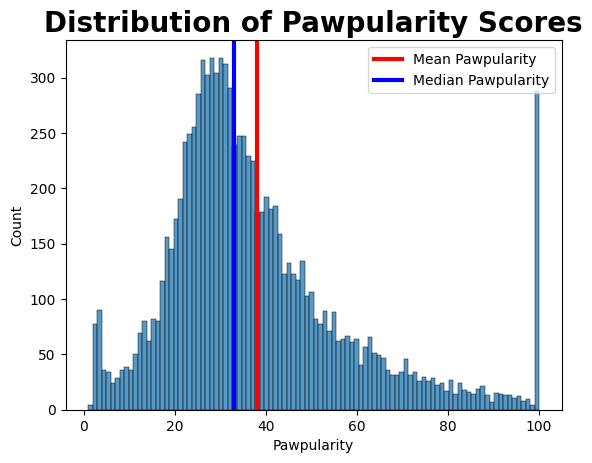

The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.59199010577444
There are 100 unique values of Pawpularity score


In [10]:
#To check the distribution of Pawpularity Scores

helpers.plotDistribution(train_df)

print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")
print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")


> From the distribution graph above, we can see that pets with Pawpularity score 20 to 40 are more, Also there is a high peak at 100 score, but before that most of the pets have the score from around ~60 - ~90 .  

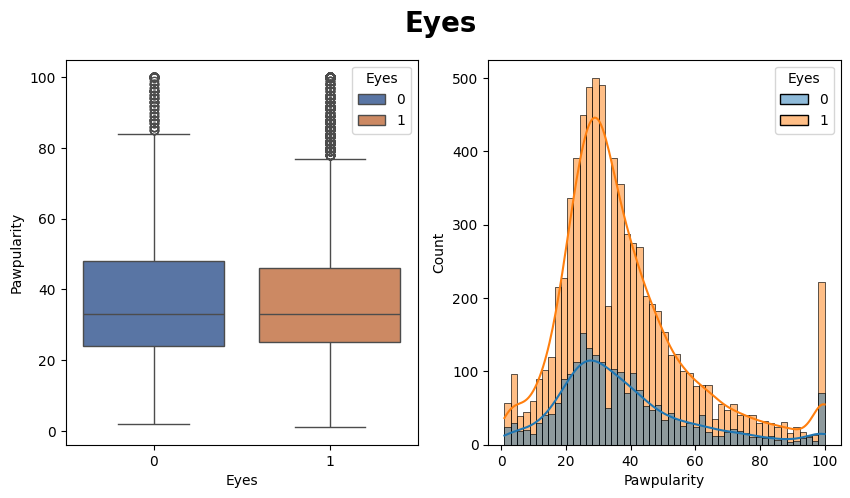

In [11]:
#showing one feature with the Pawpularity
helpers.plotDistributionAcrossEachFeature(["Eyes"],train_df)

> For the single feature like "Eye", both categories "0", "1" are similar as shown in the box plot, However we can see that those with high pawpularity are mostly the pets facing front or near-front, with at least 1 eye / pupil decently clear. 

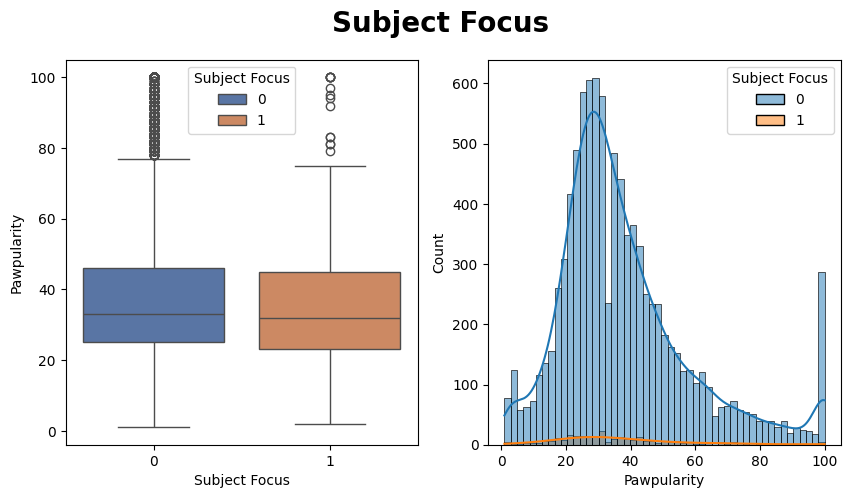

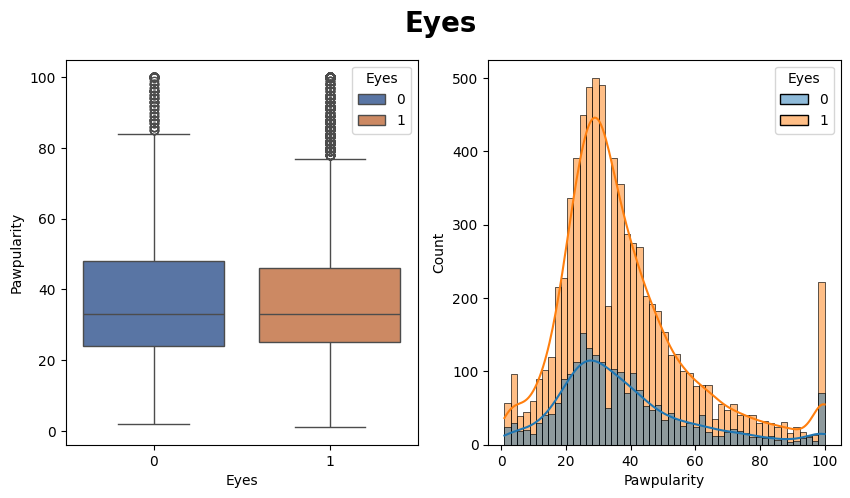

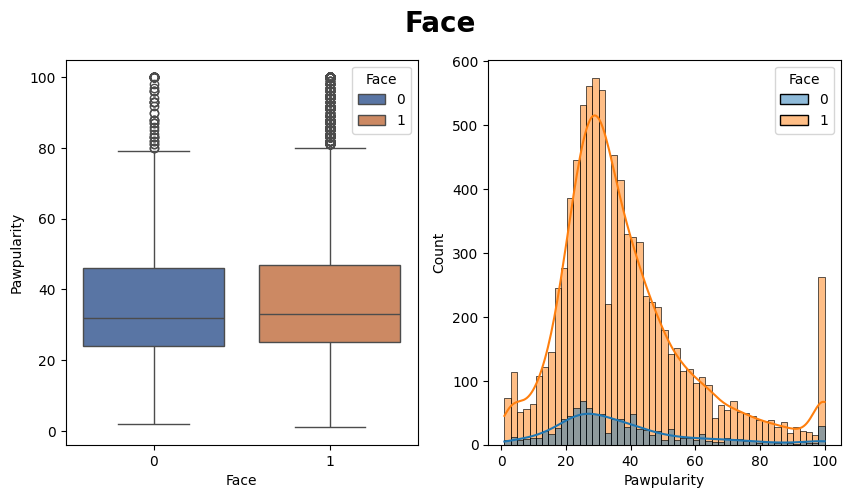

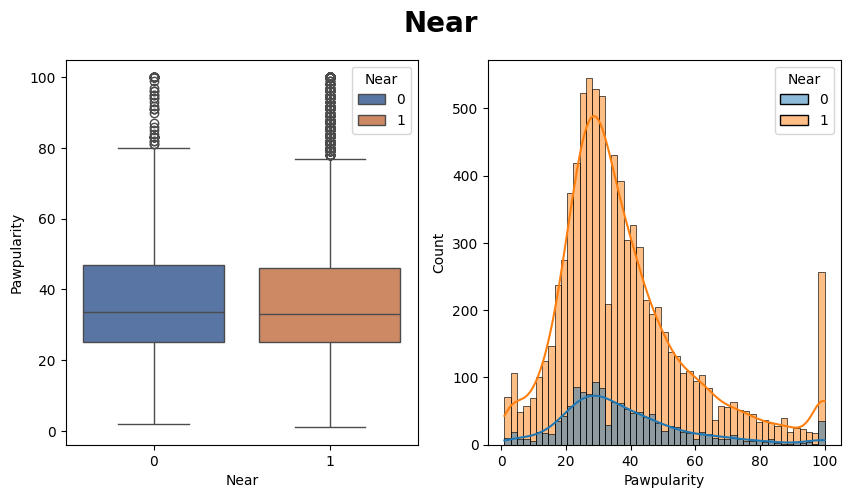

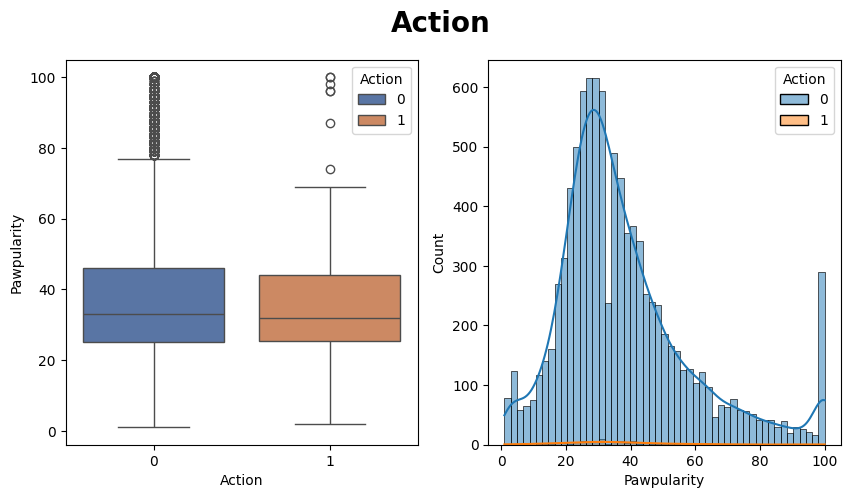

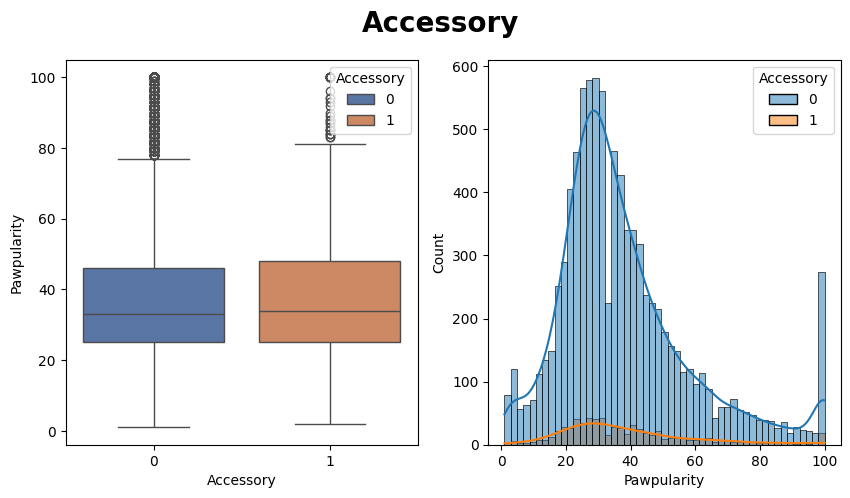

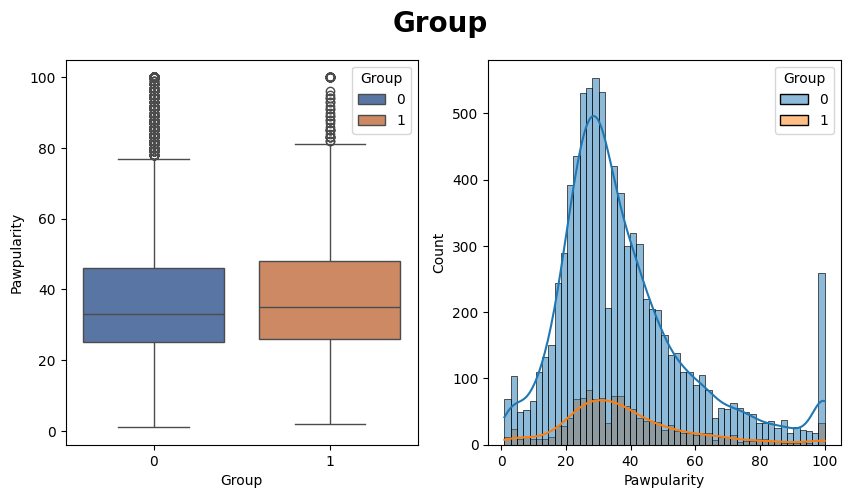

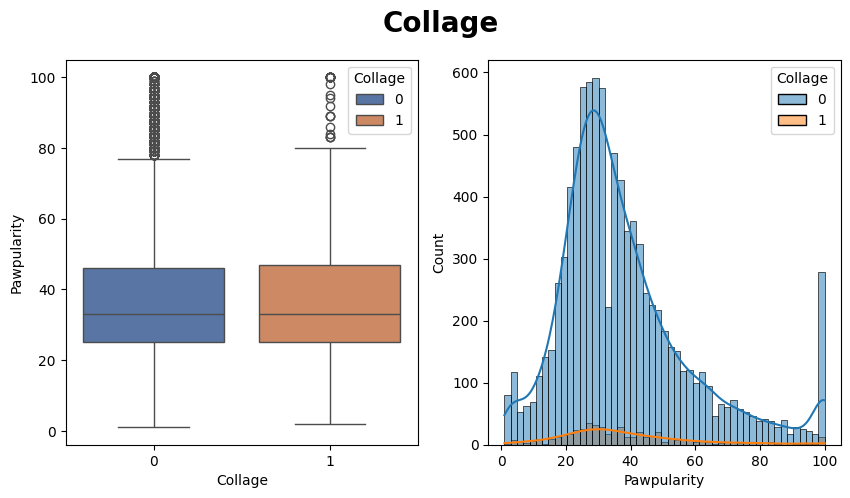

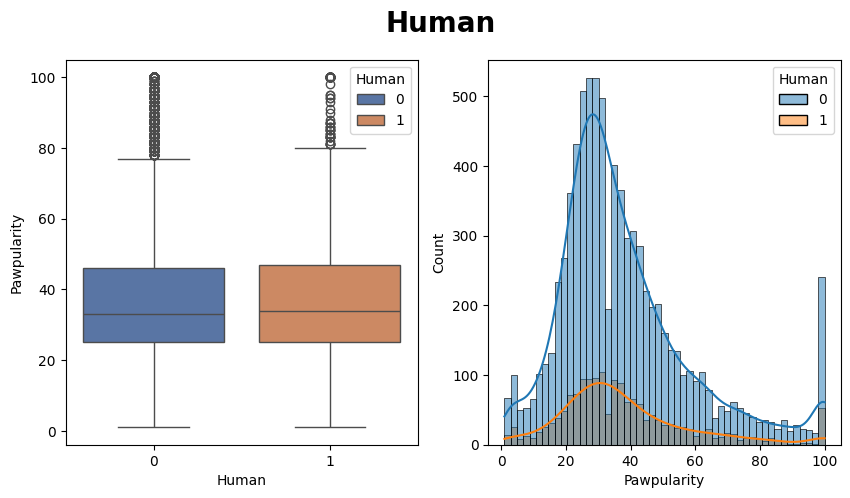

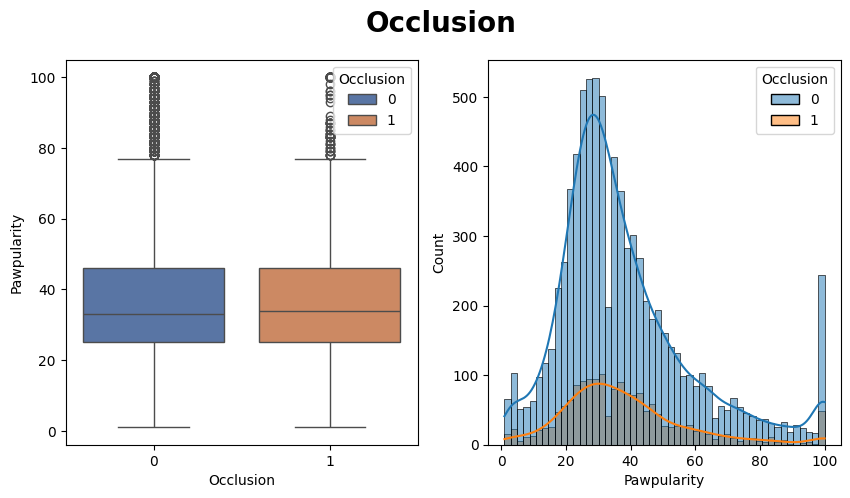

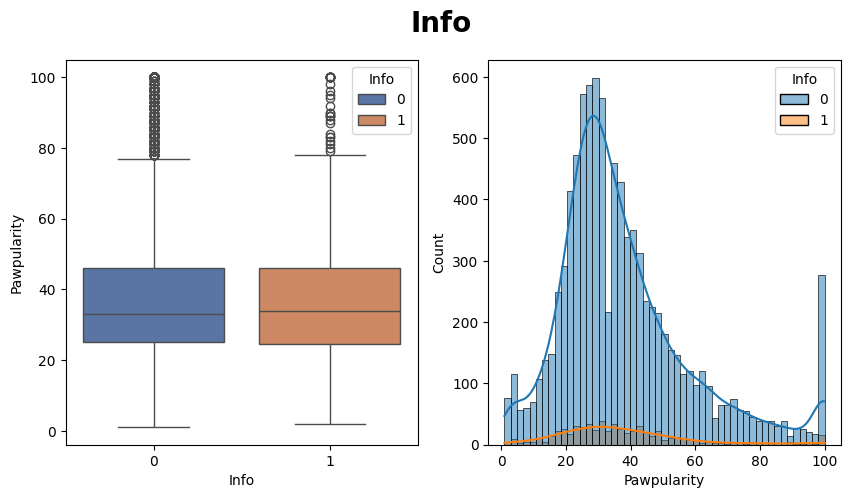

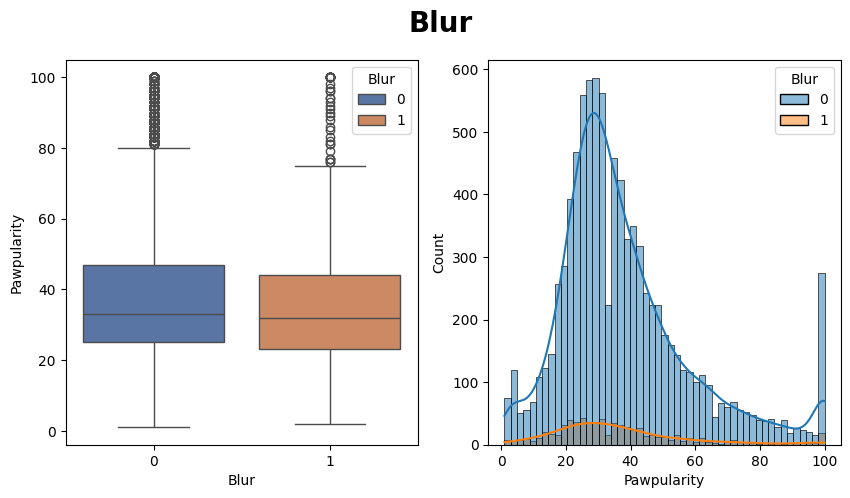

In [12]:
# Let's all features
feature_variables = train_df.columns.values.tolist()[1:-1] #to exclude id and Pawpularity
helpers.plotDistributionAcrossEachFeature(feature_variables,train_df)

### Week-1,Feedback 1
(Assignment: Add the correlation matrix and VIF calculation code to your notebook, and make sure to include explanatory comments.)

> Looking at the above distribtions, we can see the usually the pets with less blur, no object or human inclusion, without frame and tools, near are labelled with high score, Now let's check if there is any correlation between the feature and pawpularity as well as multicollinearity which describe if the features are correlated with each other (we can use correlation matrix and VIF- Variance Inflation Factor )

1. Correlation Matrix shows the how two variable are related/affected by each other
2. VIF describes how one variable is related with all other input features

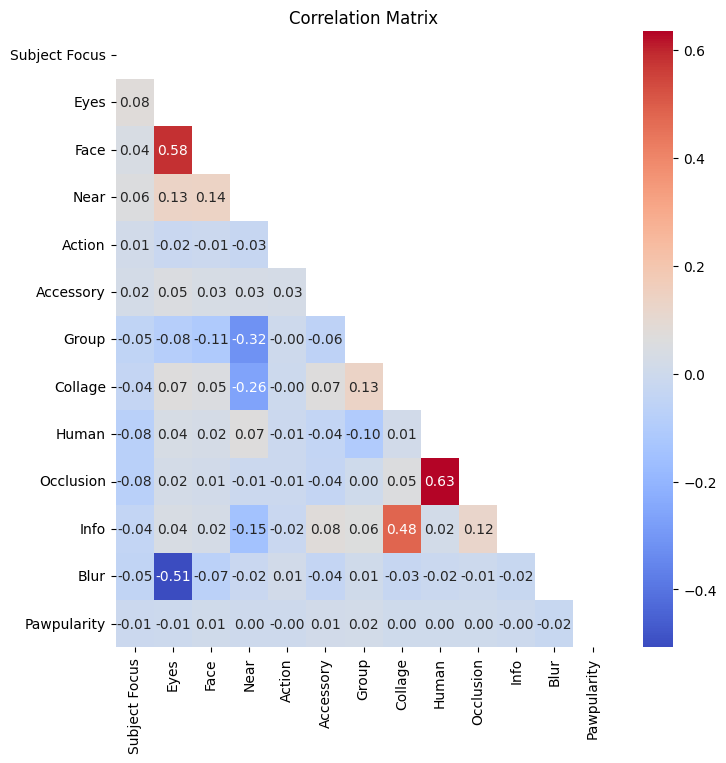

Subject Focus   -0.009853
Eyes            -0.006686
Face             0.008018
Near             0.001001
Action          -0.001373
Accessory        0.013287
Group            0.016469
Collage          0.001732
Human            0.003983
Occlusion        0.001979
Info            -0.004735
Blur            -0.023540
Name: Pawpularity, dtype: float64


In [13]:

helpers.plotCorrelationMatrix(train_df)


> Here we can see that there is not much significance correlation between the feature and pawpuarlity, However there is some little correlation between the input features like Face and Eyes, Human and Occlusion.

>   The first between Occlusion and Human (Humans can hide part of the animal)
The second between Face and Eyes which means If the face is clear and front-facing, chances are both eyes are also visible and clear. 

In [14]:
helpers.calculateVIF(train_df.loc[:, ~train_df.columns.isin(["Id", "Pawpularity"])])

,feature,VIF
2,Face,13.715668
1,Eyes,10.118170
3,Near,5.762924
9,Occlusion,2.073562
8,Human,2.064939
11,Blur,1.595109
7,Collage,1.452023
10,Info,1.412621
6,Group,1.163850
5,Accessory,1.090942


> #### Here we can see that Face and Eyes are high correclated, which signal to use some regularization when we apply model on meta data

### Now let's explore images

In [15]:
id_stem = Path(train_jpg[0]).stem
print('Original: ', train_jpg[0])
print('After: ', id_stem)


Original:  src/inputs/train\0007de18844b0dbbb5e1f607da0606e0.jpg
After:  0007de18844b0dbbb5e1f607da0606e0


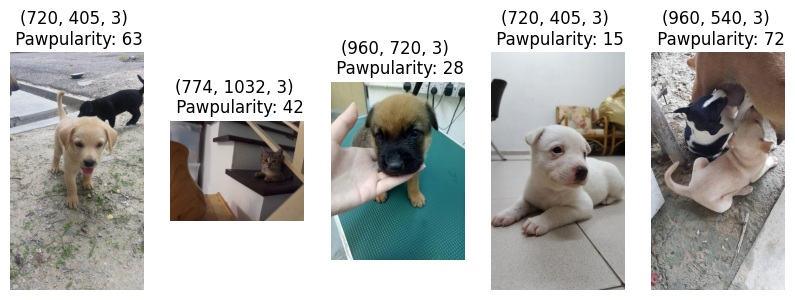

In [16]:
#let's see first 5 images
helpers.showPicture(5, train_jpg, train_df)

In [17]:
#Let's see the lowest and highest score images
print(train_df["Pawpularity"].max())
print(train_df["Pawpularity"].min())


100
1


In [18]:
train_df_max_id =  train_df.loc[train_df["Pawpularity"] == train_df["Pawpularity"].max(),"Id"].iloc[0]
train_df_min_id =  train_df.loc[train_df["Pawpularity"] == train_df["Pawpularity"].min(),"Id"].iloc[0]

In [19]:
filtered_jpg = [p for p in train_jpg if Path(p).stem in [train_df_max_id,train_df_min_id]]

##### let's check the high Pawpularity and low Pawpularity images

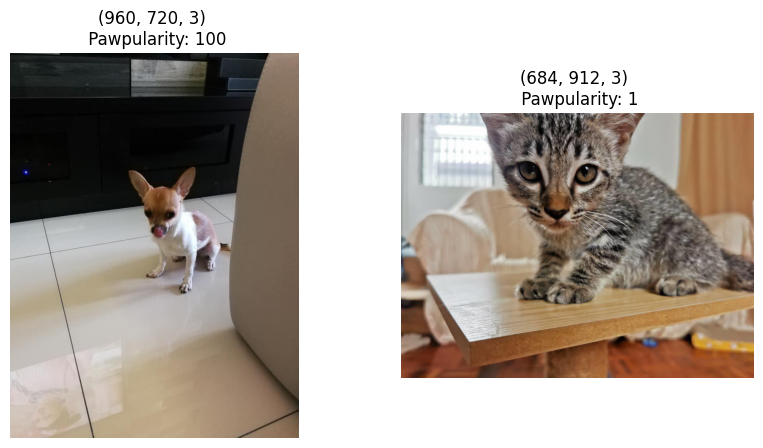

In [20]:
helpers.showPicture(2, filtered_jpg, train_df)

In [21]:
train_df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


<br>



### Week-1, Feedback 2
 (Add the code for computing image features(Brightness, Contrast, saturation, sharpness, edge density, resolution, aspect ratio) and visualizing their relationship with the target to your notebook, and include explanatory comments)

> Now we will check some other pattern from image and will their correlation with target pawpularity 

In [8]:
len(train_df)
# adding the image path to the metadata table
train_df['path'] = train_df['Id'].map(lambda x:str(BASE_PATH+'train/'+x)+'.jpg')

In [9]:

# this function will calculate edges, brightness,contrast etc for each image 
features_list = helpers.extractFeature(train_df)
print(len(features_list))


9912


In [10]:
img_features_df = pd.DataFrame(features_list)

# Merging with metadata table
merged_df = train_df.merge(img_features_df, on='Id')

print(len(merged_df))

9912


In [11]:
merged_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,...,Pawpularity,path,brightness,contrast,saturation,sharpness,edge_density,width,height,aspect_ratio
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,...,63,src/inputs/train/0007de18844b0dbbb5e1f607da060...,149.636001,47.226252,26.977051,4434.230369,0.221547,405,720,0.562500
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,...,42,src/inputs/train/0009c66b9439883ba2750fb825e1d...,95.569681,55.386129,65.260191,28.845254,0.009222,1032,774,1.333333
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,...,28,src/inputs/train/0013fd999caf9a3efe1352ca1b0d9...,117.427021,58.077102,100.025308,151.709166,0.037694,720,960,0.750000
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,...,15,src/inputs/train/0018df346ac9c1d8413cfcc888ca8...,156.972733,50.189218,27.387541,418.406313,0.028875,405,720,0.562500
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,...,72,src/inputs/train/001dc955e10590d3ca4673f034fee...,129.294448,54.795065,35.232224,2241.652292,0.156723,540,960,0.562500


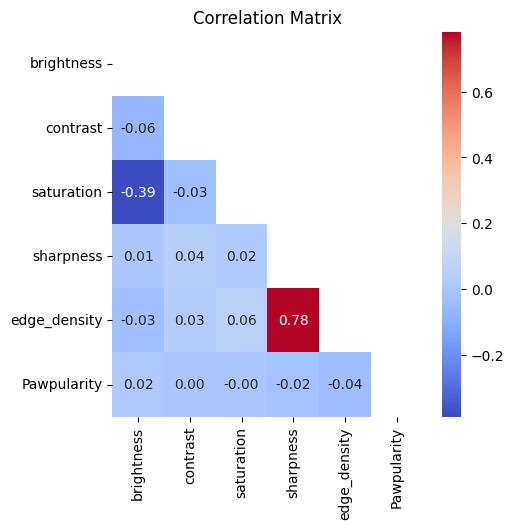

brightness      0.017841
contrast        0.001438
saturation     -0.003212
sharpness      -0.020849
edge_density   -0.036936
Name: Pawpularity, dtype: float64


In [12]:

added_features = ['Id','brightness', 'contrast', 'saturation', 'sharpness', 'edge_density','Pawpularity']
helpers.plotCorrelationMatrix(merged_df[added_features],figsize=(5,5))

> None of these individual image features have a strong  correlation with Pawpularity. 

# 2 Proposed SWIN Transformer with images + metadata


In [13]:
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,1,1,1,0,0,0,0,0,0,0,0,40,src/inputs/train/48d53aeabee4f92f77eee3a323343...
1,0,1,1,0,0,0,0,1,0,0,0,0,64,src/inputs/train/b60e82fd313066b801fa4431d1ce4...
2,0,1,1,1,0,1,0,0,0,0,0,0,26,src/inputs/train/09ae71fc4eda1e0ae05680d1950bc...
3,0,0,1,1,0,0,1,0,0,0,0,0,73,src/inputs/train/263879abce68de4af02ef5f7ef873...
4,0,1,1,1,0,0,1,0,0,0,0,0,39,src/inputs/train/4ea0587a137c7983ca92851b6cb36...


In [14]:
#normalizing 
train_df['norm_score'] = train_df['Pawpularity']/100
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score
0,0,1,1,1,0,0,0,0,0,0,0,0,40,src/inputs/train/48d53aeabee4f92f77eee3a323343...,0.40
1,0,1,1,0,0,0,0,1,0,0,0,0,64,src/inputs/train/b60e82fd313066b801fa4431d1ce4...,0.64
2,0,1,1,1,0,1,0,0,0,0,0,0,26,src/inputs/train/09ae71fc4eda1e0ae05680d1950bc...,0.26
3,0,0,1,1,0,0,1,0,0,0,0,0,73,src/inputs/train/263879abce68de4af02ef5f7ef873...,0.73
4,0,1,1,1,0,0,1,0,0,0,0,0,39,src/inputs/train/4ea0587a137c7983ca92851b6cb36...,0.39


<Axes: >

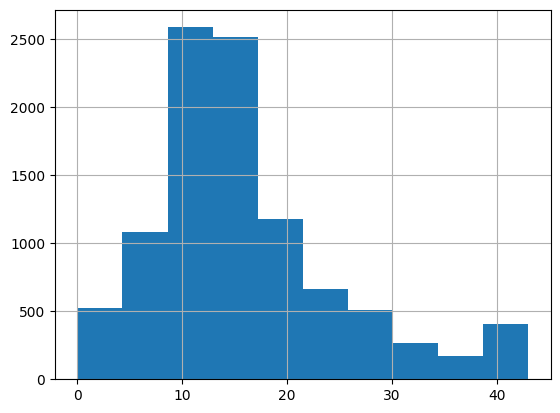

In [15]:
import numpy as np
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
# num_bins
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

<Axes: xlabel='fold'>

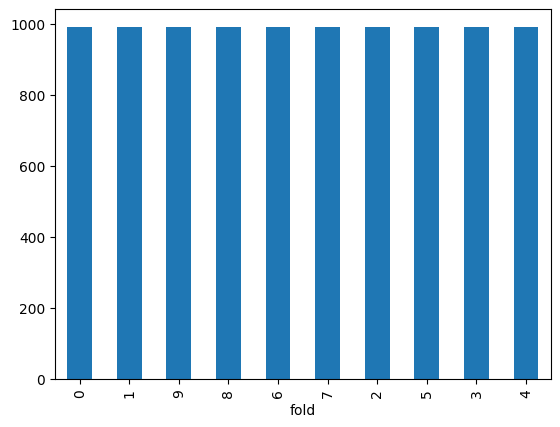

In [16]:

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
seed = 999
train_df['fold'] = -1

N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [17]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

glove_model = load_glove_model(BASE_PATH+"glove.6B.50d.txt")

Loading Glove Model
400000 words loaded!


In [18]:
import torch
feature_keys = [
    'focus', 'eyes', 'face', 'near', 'action', 'accessory',
    'group', 'collage', 'human', 'occlusion', 'info', 'blur'
]

metadata_glove = torch.zeros(len(feature_keys), 50).cuda()

for i, key in enumerate(feature_keys):
    metadata_glove[i] = torch.tensor(glove_model[key])


In [19]:
glove_model

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01]),
 ',': array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
        -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
        -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
        -0.41634 , -0.15428 ,  0.1

In [20]:

# Show 5 sample words and their vectors
for i, (word, vector) in enumerate(glove_model.items()):
    print(f"{word}: {vector[:10]}...")  # Show only first 10 dimensions 
    if i == 4:
        break


the: [ 0.418       0.24968    -0.41242     0.1217      0.34527    -0.044457
 -0.49688    -0.17862    -0.00066023 -0.6566    ]...
,: [ 0.013441  0.23682  -0.16899   0.40951   0.63812   0.47709  -0.42852
 -0.55641  -0.364    -0.23938 ]...
.: [ 0.15164  0.30177 -0.16763  0.17684  0.31719  0.33973 -0.43478 -0.31086
 -0.44999 -0.29486]...
of: [ 0.70853  0.57088 -0.4716   0.18048  0.54449  0.72603  0.18157 -0.52393
  0.10381 -0.17566]...
to: [ 0.68047  -0.039263  0.30186  -0.17792   0.42962   0.032246 -0.41376
  0.13228  -0.29847  -0.085253]...


In [21]:
train_df

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score,bins,fold
0,0,1,1,1,0,0,0,0,0,0,0,0,40,src/inputs/train/48d53aeabee4f92f77eee3a323343...,0.40,17,8
1,0,1,1,0,0,0,0,1,0,0,0,0,64,src/inputs/train/b60e82fd313066b801fa4431d1ce4...,0.64,27,9
2,0,1,1,1,0,1,0,0,0,0,0,0,26,src/inputs/train/09ae71fc4eda1e0ae05680d1950bc...,0.26,11,7
3,0,0,1,1,0,0,1,0,0,0,0,0,73,src/inputs/train/263879abce68de4af02ef5f7ef873...,0.73,31,1
4,0,1,1,1,0,0,1,0,0,0,0,0,39,src/inputs/train/4ea0587a137c7983ca92851b6cb36...,0.39,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,0,1,1,1,0,0,0,0,1,1,0,0,31,src/inputs/train/94773ee6f04891c99bc4d37e8f20f...,0.31,13,5
9908,0,1,1,1,0,0,0,0,0,0,0,0,25,src/inputs/train/85e7146eeb13644b1bac74b684ccf...,0.25,10,0
9909,0,1,1,1,0,0,0,0,0,0,0,0,60,src/inputs/train/8afb263d779be24c94f01046e5ec3...,0.60,26,2
9910,0,1,1,1,0,0,0,0,1,0,0,0,66,src/inputs/train/15bda3335526d2ab18834c65f93ad...,0.66,28,9


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import timm
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import gc
import os

In [23]:

IMAGE_SIZE = 384 
BATCH_SIZE = 16 
MODEL_NAME = 'swin_large_patch4_window12_384'

SEED = 999
N_FOLDS = 10
EPOCHS_META = 10
EPOCHS_IMAGE = 5
LR_IMAGE = 2e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [24]:
# ============================================================================
# Datasets
# ============================================================================
class MetadataDataset(Dataset):
    def __init__(self, df):
        self.metadata = df[['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 
                            'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 
                            'Info', 'Blur']].values.astype(np.float32)
        self.targets = (df['Pawpularity'].values / 100.0).astype(np.float32)
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.metadata[idx]), torch.tensor(self.targets[idx])

class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.paths = df['path'].values
        self.targets = (df['Pawpularity'].values / 100.0).astype(np.float32)
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image=image)['image']
        
        return image, torch.tensor(self.targets[idx])


In [25]:
# Augmentations 
def get_train_transforms():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_valid_transforms():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

In [26]:

class PawpularModel_meta(nn.Module):
    def __init__(self, reduction_dim=5, batch_size=BATCH_SIZE):
        super().__init__()
        self.batch_size = batch_size
        self.reduce_d = nn.Linear(50, reduction_dim)
        self.meta_order1 = nn.Linear(432 + 60, 100)
        self.meta_order2 = nn.Linear(100, 10)
        self.meta_order3 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, features):
        actual_batch_size = features.size(0)
        
        # Create embeddings
        embed = torch.zeros(actual_batch_size, *metadata_glove.shape).to(features.device)
        for idx, eve_feature in enumerate(features):
            embed[idx] = (eve_feature * metadata_glove.T).T
        
        # Reduce dimension
        embed_reduce = self.reduce_d(embed)
        
        # Normalize
        embed_norm = torch.norm(embed_reduce, dim=2, keepdim=True).clamp(min=1e-8)
        embed_reduce = embed_reduce / embed_norm
        
        # High-order interactions
        dot_result = torch.bmm(embed_reduce, embed_reduce.permute(0, 2, 1)).reshape(actual_batch_size, -1)
        dot_tanh = torch.tanh(dot_result)
        dot_relu = F.relu(dot_result)
        dot_sig = torch.sigmoid(dot_result)
        
        # Concatenate
        hig_order = torch.cat([dot_tanh, dot_relu, dot_sig], 1)
        all_order = torch.cat([embed_reduce.reshape(actual_batch_size, -1), hig_order], 1)
        
        # MLP
        out1 = self.meta_order1(self.dropout(all_order))
        out2 = self.meta_order2(self.dropout(out1))
        out3 = self.meta_order3(self.dropout(out2))
        
        return out3

In [27]:

class PawpularModel_image(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=1)
        
    def forward(self, x):
        return self.model(x)

In [28]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [29]:

def train_meta_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(loader, desc='Training Meta')
    for metadata, targets in pbar:
        metadata = metadata.to(DEVICE)
        targets = targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(metadata)
        loss = petfinder_rmse(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return running_loss / len(loader)


In [30]:
def validate_meta(model, loader):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for metadata, targets in tqdm(loader, desc='Validating Meta'):
            metadata = metadata.to(DEVICE)
            targets = targets.to(DEVICE)
            
            outputs = model(metadata)
            loss = petfinder_rmse(outputs, targets)
            running_loss += loss.item()
    
    return running_loss / len(loader)

In [31]:
def train_image_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(loader, desc='Training Image')
    for images, targets in pbar:
        images = images.to(DEVICE)
        targets = targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.binary_cross_entropy_with_logits(outputs.flatten(), targets)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # Calculate RMSE for display
        rmse = petfinder_rmse(outputs, targets)
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'rmse': f'{rmse.item():.4f}'})
    
    return running_loss / len(loader)


In [32]:
def validate_image(model, loader):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for images, targets in tqdm(loader, desc='Validating Image'):
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)
            
            outputs = model(images)
            loss = petfinder_rmse(outputs, targets)
            running_loss += loss.item()
    
    return running_loss / len(loader)

In [34]:

def train_fold(fold, train_df, val_df, save_dir='models'):
    Path(save_dir).mkdir(exist_ok=True)
    
    print(f'\n{"="*50}')
    print(f'Fold {fold} results')
    print(f'{"="*50}')
    

    print('\n--- Training Metadata Model ---')
    
    meta_train_dataset = MetadataDataset(train_df)
    meta_val_dataset = MetadataDataset(val_df)
    
    meta_train_loader = DataLoader(
        meta_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=0, pin_memory=True, drop_last=True
    )
    meta_val_loader = DataLoader(
        meta_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, pin_memory=True
    )
    
    meta_model = PawpularModel_meta(batch_size=BATCH_SIZE).to(DEVICE)
    meta_optimizer = torch.optim.Adam(meta_model.parameters(), lr=1e-3)
    
    best_meta_rmse = float('inf')
    patience_counter = 0
    
    for epoch in range(1, EPOCHS_META + 1):
        train_loss = train_meta_epoch(meta_model, meta_train_loader, meta_optimizer)
        val_rmse = validate_meta(meta_model, meta_val_loader)
        
        print(f'Epoch {epoch}/{EPOCHS_META} - Train Loss: {train_loss:.4f}, Val RMSE: {val_rmse:.4f}')
        
        if val_rmse < best_meta_rmse:
            best_meta_rmse = val_rmse
            patience_counter = 0
            torch.save(meta_model.state_dict(), f'{save_dir}/meta_model_fold_{fold}.pth')
        else:
            patience_counter += 1
            if patience_counter >= 2:
                print(f'Early stopping triggered at epoch {epoch}')
                break
    
    val_mse_meta = best_meta_rmse
    print(f'Best Meta RMSE: {val_mse_meta:.4f}')
    
    # Cleanup
    del meta_model, meta_optimizer
    del meta_train_loader, meta_val_loader
    torch.cuda.empty_cache()
    gc.collect()
    
    print('meta process is done!')
    
  
    print('\n--- Training Image Model ---')
    
    image_train_dataset = ImageDataset(train_df, transform=get_train_transforms())
    image_val_dataset = ImageDataset(val_df, transform=get_valid_transforms())
    
    image_train_loader = DataLoader(
        image_train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=0, pin_memory=True, drop_last=True
    )
    image_val_loader = DataLoader(
        image_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, pin_memory=True
    )
    
    image_model = PawpularModel_image().to(DEVICE)
    image_optimizer = torch.optim.AdamW(image_model.parameters(), lr=LR_IMAGE, weight_decay=1e-6)
    
    best_image_rmse = float('inf')
    patience_counter = 0
    
    for epoch in range(1, EPOCHS_IMAGE + 1):
        print(f"\nEpoch {epoch}/{EPOCHS_IMAGE}")
        train_loss = train_image_epoch(image_model, image_train_loader, image_optimizer)
        val_rmse = validate_image(image_model, image_val_loader)
        
        print(f'Epoch {epoch}/{EPOCHS_IMAGE} - Train Loss: {train_loss:.4f}, Val RMSE: {val_rmse:.4f}')
        
        if val_rmse < best_image_rmse:
            best_image_rmse = val_rmse
            patience_counter = 0
            torch.save(image_model.state_dict(), f'{save_dir}/image_model_fold_{fold}.pth')
        else:
            patience_counter += 1
            if patience_counter >= 2:
                print(f'Early stopping triggered at epoch {epoch}')
                break
    
    val_mse_pic = best_image_rmse
    print(f'Best Image RMSE: {val_mse_pic:.4f}')
    
    # Cleanup
    del image_model, image_optimizer
    del image_train_loader, image_val_loader
    torch.cuda.empty_cache()
    gc.collect()
    
    print('pic process is done!')
    
   
    meta_weight = F.relu(torch.tensor(20.5 - val_mse_meta)) ** 2
    pic_weight = F.relu(torch.tensor(20.5 - val_mse_pic)) ** 2
    
    # Normalize
    total_weight = meta_weight + pic_weight
    meta_weight = meta_weight / total_weight
    pic_weight = pic_weight / total_weight
    
    print(f'meta_weight is {meta_weight.item():.4f}')
    print(f'pic_weight is {pic_weight.item():.4f}')
    
    # Calculate ensemble RMSE
    ensemble_rmse = val_mse_meta * meta_weight.item() + val_mse_pic * pic_weight.item()
    print(f'Estimated Ensemble RMSE: {ensemble_rmse:.4f}')
    
    # Save results
    torch.save({
        'fold': fold,
        'val_mse_meta': val_mse_meta,
        'val_mse_pic': val_mse_pic,
        'meta_weight': meta_weight.item(),
        'pic_weight': pic_weight.item(),
        'ensemble_rmse': ensemble_rmse
    }, f'{save_dir}/fold_{fold}_results.pth')
    
    return ensemble_rmse


In [27]:
# ============================================================================
# Training loop
# ============================================================================
results = []

for fold in range(N_FOLDS):
    train_fold_df = train_df[train_df['fold'] != fold].reset_index(drop=True)
    val_fold_df = train_df[train_df['fold'] == fold].reset_index(drop=True)
    
    ensemble_rmse = train_fold(fold, train_fold_df, val_fold_df)
    
    results.append({
        'fold': fold,
        'validation_rmse': ensemble_rmse
    })

# Summary
print(f'\n{"="*50}')
print('Training Complete!')
print(f'{"="*50}')

for result in results:
    print(f"Fold {result['fold']}: RMSE = {result['validation_rmse']:.4f}")

avg_rmse = np.mean([r['validation_rmse'] for r in results])
print(f'\nFinal Average Validation RMSE: {avg_rmse:.4f}')

results.append({
    'fold': 'average',
    'validation_rmse': avg_rmse
})


Fold 0 results

--- Training Metadata Model ---


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 889.48it/s]


Epoch 1/10 - Train Loss: 21.3464, Val RMSE: 20.2918


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 874.52it/s]


Epoch 2/10 - Train Loss: 20.3650, Val RMSE: 20.4219


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 858.72it/s]


Epoch 3/10 - Train Loss: 20.2932, Val RMSE: 20.4033
Early stopping triggered at epoch 3
Best Meta RMSE: 20.2918
meta process is done!

--- Training Image Model ---

Epoch 1/5


Validating Image: 100%|██████████| 62/62 [05:42<00:00,  5.52s/it]


Epoch 1/5 - Train Loss: 0.6501, Val RMSE: 17.8018

Epoch 2/5


Validating Image: 100%|██████████| 62/62 [05:49<00:00,  5.64s/it]


Epoch 2/5 - Train Loss: 0.6401, Val RMSE: 17.8052

Epoch 3/5


Validating Image: 100%|██████████| 62/62 [05:32<00:00,  5.37s/it]


Epoch 3/5 - Train Loss: 0.6337, Val RMSE: 17.8460
Early stopping triggered at epoch 3
Best Image RMSE: 17.8018
pic process is done!
meta_weight is 0.0059
pic_weight is 0.9941
Estimated Ensemble RMSE: 17.8166

Fold 1 results

--- Training Metadata Model ---


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 853.11it/s]


Epoch 1/10 - Train Loss: 21.9109, Val RMSE: 20.4248


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 832.45it/s]


Epoch 2/10 - Train Loss: 20.7624, Val RMSE: 20.1943


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 811.19it/s]


Epoch 3/10 - Train Loss: 20.3943, Val RMSE: 20.1262


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 849.19it/s]


Epoch 4/10 - Train Loss: 20.2654, Val RMSE: 20.1037


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 748.07it/s]


Epoch 5/10 - Train Loss: 20.1776, Val RMSE: 20.0827


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 841.19it/s]


Epoch 6/10 - Train Loss: 20.0912, Val RMSE: 20.0915


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 853.24it/s]


Epoch 7/10 - Train Loss: 20.0700, Val RMSE: 20.0902
Early stopping triggered at epoch 7
Best Meta RMSE: 20.0827
meta process is done!

--- Training Image Model ---

Epoch 1/5


Validating Image: 100%|██████████| 62/62 [05:38<00:00,  5.46s/it]


Epoch 1/5 - Train Loss: 0.6509, Val RMSE: 16.8742

Epoch 2/5


Validating Image: 100%|██████████| 62/62 [05:39<00:00,  5.47s/it]


Epoch 2/5 - Train Loss: 0.6409, Val RMSE: 17.1015

Epoch 3/5


Validating Image: 100%|██████████| 62/62 [05:36<00:00,  5.43s/it]


Epoch 3/5 - Train Loss: 0.6339, Val RMSE: 16.5832

Epoch 4/5


Validating Image: 100%|██████████| 62/62 [05:42<00:00,  5.52s/it]


Epoch 4/5 - Train Loss: 0.6254, Val RMSE: 16.8224

Epoch 5/5


Validating Image: 100%|██████████| 62/62 [06:20<00:00,  6.13s/it]


Epoch 5/5 - Train Loss: 0.6167, Val RMSE: 17.4107
Early stopping triggered at epoch 5
Best Image RMSE: 16.5832
pic process is done!
meta_weight is 0.0112
pic_weight is 0.9888
Estimated Ensemble RMSE: 16.6225

Fold 2 results

--- Training Metadata Model ---


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 370.75it/s]


Epoch 1/10 - Train Loss: 21.8861, Val RMSE: 20.0519


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 818.24it/s]


Epoch 2/10 - Train Loss: 20.7652, Val RMSE: 20.0693


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 840.01it/s]


Epoch 3/10 - Train Loss: 20.3363, Val RMSE: 20.1505
Early stopping triggered at epoch 3
Best Meta RMSE: 20.0519
meta process is done!

--- Training Image Model ---

Epoch 1/5


Validating Image: 100%|██████████| 62/62 [05:10<00:00,  5.01s/it]


Epoch 1/5 - Train Loss: 0.6497, Val RMSE: 17.6003

Epoch 2/5


Validating Image: 100%|██████████| 62/62 [05:15<00:00,  5.08s/it]


Epoch 2/5 - Train Loss: 0.6397, Val RMSE: 17.4465

Epoch 3/5


Validating Image: 100%|██████████| 62/62 [05:08<00:00,  4.97s/it]


Epoch 3/5 - Train Loss: 0.6338, Val RMSE: 17.6410

Epoch 4/5


Validating Image: 100%|██████████| 62/62 [07:01<00:00,  6.81s/it]


Epoch 4/5 - Train Loss: 0.6268, Val RMSE: 17.5597
Early stopping triggered at epoch 4
Best Image RMSE: 17.4465
pic process is done!
meta_weight is 0.0211
pic_weight is 0.9789
Estimated Ensemble RMSE: 17.5014

Fold 3 results

--- Training Metadata Model ---


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 891.17it/s]


Epoch 1/10 - Train Loss: 21.1637, Val RMSE: 20.2148


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 847.96it/s]


Epoch 2/10 - Train Loss: 20.2056, Val RMSE: 20.1411


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 817.92it/s]


Epoch 3/10 - Train Loss: 20.1049, Val RMSE: 20.1475


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 845.61it/s]


Epoch 4/10 - Train Loss: 20.0594, Val RMSE: 20.1433
Early stopping triggered at epoch 4
Best Meta RMSE: 20.1411
meta process is done!

--- Training Image Model ---

Epoch 1/5


Validating Image: 100%|██████████| 62/62 [05:16<00:00,  5.11s/it]


Epoch 1/5 - Train Loss: 0.6497, Val RMSE: 17.2804

Epoch 2/5


Validating Image: 100%|██████████| 62/62 [05:23<00:00,  5.21s/it]


Epoch 2/5 - Train Loss: 0.6398, Val RMSE: 17.0300

Epoch 3/5


Validating Image: 100%|██████████| 62/62 [05:15<00:00,  5.08s/it]


Epoch 3/5 - Train Loss: 0.6335, Val RMSE: 17.3306

Epoch 4/5


Validating Image: 100%|██████████| 62/62 [05:13<00:00,  5.06s/it]


Epoch 4/5 - Train Loss: 0.6267, Val RMSE: 17.4963
Early stopping triggered at epoch 4
Best Image RMSE: 17.0300
pic process is done!
meta_weight is 0.0106
pic_weight is 0.9894
Estimated Ensemble RMSE: 17.0629

Fold 4 results

--- Training Metadata Model ---


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 677.79it/s]


Epoch 1/10 - Train Loss: 21.4360, Val RMSE: 20.2360


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 817.83it/s]


Epoch 2/10 - Train Loss: 20.3896, Val RMSE: 20.0407


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 796.36it/s]


Epoch 3/10 - Train Loss: 20.1666, Val RMSE: 19.9206


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 782.83it/s]


Epoch 4/10 - Train Loss: 20.1206, Val RMSE: 19.9009


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 711.47it/s]


Epoch 5/10 - Train Loss: 20.1414, Val RMSE: 19.9724


Validating Meta: 100%|██████████| 62/62 [00:00<00:00, 841.79it/s]


Epoch 6/10 - Train Loss: 20.0818, Val RMSE: 19.9013
Early stopping triggered at epoch 6
Best Meta RMSE: 19.9009
meta process is done!

--- Training Image Model ---

Epoch 1/5


Validating Image: 100%|██████████| 62/62 [05:14<00:00,  5.07s/it]


Epoch 1/5 - Train Loss: 0.6513, Val RMSE: 17.2927

Epoch 2/5


Validating Image: 100%|██████████| 62/62 [05:07<00:00,  4.96s/it]


Epoch 2/5 - Train Loss: 0.6403, Val RMSE: 17.4052

Epoch 3/5


Validating Image: 100%|██████████| 62/62 [05:01<00:00,  4.86s/it]


Epoch 3/5 - Train Loss: 0.6333, Val RMSE: 17.2135

Epoch 4/5


Validating Image: 100%|██████████| 62/62 [06:13<00:00,  6.02s/it]


Epoch 4/5 - Train Loss: 0.6270, Val RMSE: 17.1192

Epoch 5/5


Training Image:  75%|███████▍  | 417/557 [1:36:27<32:23, 13.88s/it, loss=0.6466, rmse=11.0588]  


KeyboardInterrupt: 

> Due to longer training time, the loop is stopped after fold 4 processing, 

# Inference

In [ ]:

#Loading the models and evaluating on the validation data
from torch.utils.data import DataLoader
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression

# ============================================================================
# MAIN EVALUATION FUNCTION
# ============================================================================
def get_meta_predictions(model, loader):
    """Get predictions from metadata model"""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for metadata, targets in tqdm(loader, desc='Meta Predictions'):
            metadata = metadata.to(DEVICE)
            outputs = model(metadata)
            preds = torch.sigmoid(outputs.flatten())
            
            all_preds.append(preds.cpu())
            all_targets.append(targets)
    
    return torch.cat(all_preds), torch.cat(all_targets)

def get_image_predictions(model, loader):
    """Get predictions from image model"""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in tqdm(loader, desc='Image Predictions'):
            images = images.to(DEVICE)
            outputs = model(images)
            preds = torch.sigmoid(outputs.flatten())
            
            all_preds.append(preds.cpu())
            all_targets.append(targets)
    
    return torch.cat(all_preds), torch.cat(all_targets)

def calculate_ensemble_rmse(meta_preds, image_preds, targets, meta_weight, image_weight):
    """Calculate TRUE ensemble RMSE by combining predictions"""
    ensemble_preds = meta_preds * meta_weight + image_preds * image_weight
    rmse = 100 * torch.sqrt(F.mse_loss(ensemble_preds, targets))
    return rmse.item()

def calculate_weights_alternative(meta_rmse, image_rmse, method='paper'):
    """
    Different weighting formulas to try
    """
    if method == 'paper':
        meta_w = F.relu(torch.tensor(20.5 - meta_rmse)) ** 2
        image_w = F.relu(torch.tensor(20.5 - image_rmse)) ** 2
    elif method == 'inverse':
        meta_w = 1.0 / meta_rmse
        image_w = 1.0 / image_rmse
    elif method == 'inverse_square':
        meta_w = 1.0 / (meta_rmse ** 2)
        image_w = 1.0 / (image_rmse ** 2)
    elif method == 'softmax':
        meta_w = torch.exp(torch.tensor(-meta_rmse / 4.0))
        image_w = torch.exp(torch.tensor(-image_rmse / 4.0))
    elif method == 'equal':
        meta_w = torch.tensor(0.5)
        image_w = torch.tensor(0.5)
    
    total = meta_w + image_w
    return (meta_w / total), (image_w / total)

def grid_search_optimal(meta_preds, image_preds, targets):
    """Find optimal weights by trying all combinations with finer steps"""
    best_rmse = float('inf')
    best_meta_w = 0.5
    
    for meta_w in np.arange(0.0, 1.01, 0.01):
        image_w = 1.0 - meta_w
        ensemble = meta_preds * meta_w + image_preds * image_w
        rmse = 100 * torch.sqrt(F.mse_loss(ensemble, targets)).item()
        if rmse < best_rmse:
            best_rmse = rmse
            best_meta_w = meta_w
    
    return best_meta_w, 1.0 - best_meta_w, best_rmse

# ============================================================================
# MODIFY evaluate_fold TO TEST MULTIPLE METHODS
# ============================================================================
def evaluate_fold(fold, val_df, save_dir='models'):
    """Load saved models and calculate TRUE ensemble RMSE with multiple methods"""
    
    print(f'\n{"="*50}')
    print(f'Evaluating Fold {fold}')
    print(f'{"="*50}')
    
    # Load saved results to get original weights
    results = torch.load(f'{save_dir}/fold_{fold}_results.pth')
    orig_meta_weight = results['meta_weight']
    orig_image_weight = results['pic_weight']
    
    # Create datasets
    meta_val_dataset = MetadataDataset(val_df)
    image_val_dataset = ImageDataset(val_df, transform=get_valid_transforms())
    
    meta_val_loader = DataLoader(
        meta_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, pin_memory=True
    )
    image_val_loader = DataLoader(
        image_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, pin_memory=True
    )
    
    # Load metadata model and get predictions
    print('Loading metadata model...')
    meta_model = PawpularModel_meta(batch_size=BATCH_SIZE).to(DEVICE)
    meta_model.load_state_dict(torch.load(f'{save_dir}/meta_model_fold_{fold}.pth'))
    meta_preds, targets = get_meta_predictions(meta_model, meta_val_loader)
    del meta_model
    torch.cuda.empty_cache()
    
    # Load image model and get predictions
    print('Loading image model...')
    image_model = PawpularModel_image().to(DEVICE)
    image_model.load_state_dict(torch.load(f'{save_dir}/image_model_fold_{fold}.pth'))
    image_preds, _ = get_image_predictions(image_model, image_val_loader)
    del image_model
    torch.cuda.empty_cache()
    
    # Calibrate predictions
    print('Calibrating predictions...')
    cal_meta = IsotonicRegression(out_of_bounds='clip').fit(meta_preds.numpy().reshape(-1,1), targets.numpy())
    cal_image = IsotonicRegression(out_of_bounds='clip').fit(image_preds.numpy().reshape(-1,1), targets.numpy())
    meta_preds_cal = torch.tensor(cal_meta.predict(meta_preds.numpy().reshape(-1,1)))
    image_preds_cal = torch.tensor(cal_image.predict(image_preds.numpy().reshape(-1,1)))
    
    # Calculate individual RMSEs
    meta_rmse = 100 * torch.sqrt(F.mse_loss(meta_preds, targets)).item()
    image_rmse = 100 * torch.sqrt(F.mse_loss(image_preds, targets)).item()
    meta_rmse_cal = 100 * torch.sqrt(F.mse_loss(meta_preds_cal, targets)).item()
    image_rmse_cal = 100 * torch.sqrt(F.mse_loss(image_preds_cal, targets)).item()
    
    print(f'\nIndividual Model Performance:')
    print(f'  Meta RMSE (raw):   {meta_rmse:.4f}')
    print(f'  Meta RMSE (cal):   {meta_rmse_cal:.4f}')
    print(f'  Image RMSE (raw):  {image_rmse:.4f}')
    print(f'  Image RMSE (cal):  {image_rmse_cal:.4f}')
    
    # Test different weighting methods on calibrated predictions
    print(f'\n{"Method":<20} {"Meta W":<10} {"Image W":<10} {"Ensemble RMSE":<15}')
    print("-" * 60)
    
    methods_results = {}
    
    # 1. Paper's original formula
    ensemble_rmse_paper = calculate_ensemble_rmse(meta_preds_cal, image_preds_cal, targets, 
                                                   orig_meta_weight, orig_image_weight)
    methods_results['paper'] = {
        'meta_w': orig_meta_weight,
        'image_w': orig_image_weight,
        'rmse': ensemble_rmse_paper
    }
    print(f'{"paper":<20} {orig_meta_weight:<10.4f} {orig_image_weight:<10.4f} {ensemble_rmse_paper:<15.4f}')
    
    # 2. Inverse
    meta_w, image_w = calculate_weights_alternative(meta_rmse_cal, image_rmse_cal, 'inverse')
    rmse = calculate_ensemble_rmse(meta_preds_cal, image_preds_cal, targets, meta_w, image_w)
    methods_results['inverse'] = {'meta_w': meta_w, 'image_w': image_w, 'rmse': rmse}
    print(f'{"inverse":<20} {meta_w:<10.4f} {image_w:<10.4f} {rmse:<15.4f}')
    
    # 3. Inverse square
    meta_w, image_w = calculate_weights_alternative(meta_rmse_cal, image_rmse_cal, 'inverse_square')
    rmse = calculate_ensemble_rmse(meta_preds_cal, image_preds_cal, targets, meta_w, image_w)
    methods_results['inverse_square'] = {'meta_w': meta_w, 'image_w': image_w, 'rmse': rmse}
    print(f'{"inverse_square":<20} {meta_w:<10.4f} {image_w:<10.4f} {rmse:<15.4f}')
    
    # 4. Softmax
    meta_w, image_w = calculate_weights_alternative(meta_rmse_cal, image_rmse_cal, 'softmax')
    rmse = calculate_ensemble_rmse(meta_preds_cal, image_preds_cal, targets, meta_w, image_w)
    methods_results['softmax'] = {'meta_w': meta_w, 'image_w': image_w, 'rmse': rmse}
    print(f'{"softmax":<20} {meta_w:<10.4f} {image_w:<10.4f} {rmse:<15.4f}')
    
    # 5. Equal weights
    meta_w, image_w = 0.5, 0.5
    rmse = calculate_ensemble_rmse(meta_preds_cal, image_preds_cal, targets, meta_w, image_w)
    methods_results['equal'] = {'meta_w': meta_w, 'image_w': image_w, 'rmse': rmse}
    print(f'{"equal":<20} {meta_w:<10.4f} {image_w:<10.4f} {rmse:<15.4f}')
    
    # 6. Optimal (grid search)
    print('Searching for optimal...')
    opt_meta_w, opt_image_w, opt_rmse = grid_search_optimal(meta_preds_cal, image_preds_cal, targets)
    methods_results['optimal'] = {'meta_w': opt_meta_w, 'image_w': opt_image_w, 'rmse': opt_rmse}
    print(f'{"optimal":<20} {opt_meta_w:<10.4f} {opt_image_w:<10.4f} {opt_rmse:<15.4f}')
    
    # 7. Stacking with Linear Regression
    print('Running stacking...')
    X_stack = np.stack([meta_preds_cal.numpy(), image_preds_cal.numpy()], axis=1)
    y = targets.numpy()
    stack_model = LinearRegression().fit(X_stack, y)
    stack_preds = torch.tensor(stack_model.predict(X_stack))
    stack_rmse = 100 * torch.sqrt(F.mse_loss(stack_preds, targets)).item()
    methods_results['stacking'] = {
        'meta_w': stack_model.coef_[0],
        'image_w': stack_model.coef_[1],
        'bias': stack_model.intercept_,
        'rmse': stack_rmse
    }
    print(f'{"stacking":<20} {stack_model.coef_[0]:<10.4f} {stack_model.coef_[1]:<10.4f} {stack_rmse:<15.4f}')
    
    # Find best method
    best_method = min(methods_results.items(), key=lambda x: x[1]['rmse'])
    print(f'\n✅ BEST for Fold {fold}: {best_method[0]} with RMSE = {best_method[1]["rmse"]:.4f}')
    
    return {
        'fold': fold,
        'meta_rmse': meta_rmse,
        'image_rmse': image_rmse,
        'meta_rmse_cal': meta_rmse_cal,
        'image_rmse_cal': image_rmse_cal,
        'methods': methods_results,
        'best_method': best_method[0],
        'best_rmse': best_method[1]['rmse']
    }

# ============================================================================
# RUN EVALUATION ON ALL FOLDS
# ============================================================================

# Evaluate all folds
all_results = []
N_FOLDS = 4
for fold in range(N_FOLDS):
    val_fold_df = train_df[train_df['fold'] == fold].reset_index(drop=True)
    result = evaluate_fold(fold, val_fold_df, save_dir='models')
    all_results.append(result)

# ============================================================================
# FINAL SUMMARY - Compare all methods
# ============================================================================
print(f'\n{"="*60}')
print('FINAL RESULTS - ALL WEIGHTING METHODS')
print(f'{"="*60}')

# Calculate averages for each method
methods = ['paper', 'inverse', 'inverse_square', 'softmax', 'equal', 'optimal', 'stacking']
method_averages = {}

for method in methods:
    avg = np.mean([r['methods'][method]['rmse'] for r in all_results])
    method_averages[method] = avg

# Sort by RMSE
sorted_methods = sorted(method_averages.items(), key=lambda x: x[1])

print(f'\n{"Rank":<6} {"Method":<20} {"Average RMSE":<15}')
print("-" * 50)
for rank, (method, avg_rmse) in enumerate(sorted_methods, 1):
    marker = " 🏆 BEST!" if rank == 1 else ""
    print(f'{rank:<6} {method:<20} {avg_rmse:<15.4f}{marker}')

best_method = sorted_methods[0][0]
best_rmse = sorted_methods[0][1]

print(f'\n{"="*60}')
print(f'✅ BEST WEIGHTING METHOD: {best_method}')
print(f'✅ FINAL VALIDATION RMSE TO REPORT: {best_rmse:.4f}')
print(f'{"="*60}')

# Show per-fold results for best method
print(f'\nPer-fold RMSE using {best_method} method:')
for result in all_results:
    print(f"  Fold {result['fold']}: {result['methods'][best_method]['rmse']:.4f}")

# Save results
final_results = {
    'fold_results': all_results,
    'method_averages': method_averages,
    'best_method': best_method,
    'best_rmse': best_rmse
}

torch.save(final_results, 'models/correct_ensemble_results.pth')
print('\n✅ Results saved to: models/correct_ensemble_results.pth')
print(f'✅ REPORT THIS RMSE: {best_rmse:.4f}')

# Also show paper's method for comparison
paper_rmse = method_averages['paper']
improvement = paper_rmse - best_rmse
print(f'\nComparison to paper formula:')
print(f'  Paper method RMSE: {paper_rmse:.4f}')
print(f'  Best method RMSE:  {best_rmse:.4f}')
print(f'  Improvement:       {improvement:.4f} ({improvement/paper_rmse*100:.2f}%)')


Evaluating Fold 0
Loading metadata model...


Meta Predictions: 100%|██████████| 62/62 [00:00<00:00, 572.81it/s]

Loading image model...



Image Predictions: 100%|██████████| 62/62 [00:50<00:00,  1.22it/s]


Calibrating predictions...

Individual Model Performance:
  Meta RMSE (raw):   20.6332
  Meta RMSE (cal):   20.5355
  Image RMSE (raw):  18.1653
  Image RMSE (cal):  17.6444

Method               Meta W     Image W    Ensemble RMSE  
------------------------------------------------------------
paper                0.0059     0.9941     17.6436        
inverse              0.4621     0.5379     18.2645        
inverse_square       0.4247     0.5753     18.1646        
softmax              0.3268     0.6732     17.9431        
equal                0.5000     0.5000     18.3741        
Searching for optimal...
optimal              0.0200     0.9800     17.6427        
Running stacking...
stacking             0.5776     0.9902     17.6013        

✅ BEST for Fold 0: stacking with RMSE = 17.6013

Evaluating Fold 1
Loading metadata model...


Meta Predictions: 100%|██████████| 62/62 [00:00<00:00, 1091.58it/s]


Loading image model...


Image Predictions: 100%|██████████| 62/62 [00:51<00:00,  1.20it/s]


Calibrating predictions...

Individual Model Performance:
  Meta RMSE (raw):   20.6015
  Meta RMSE (cal):   20.5238
  Image RMSE (raw):  17.1108
  Image RMSE (cal):  16.6672

Method               Meta W     Image W    Ensemble RMSE  
------------------------------------------------------------
paper                0.0112     0.9888     16.6666        
inverse              0.4482     0.5518     17.4876        
inverse_square       0.3974     0.6026     17.3114        
softmax              0.2760     0.7240     16.9732        
equal                0.5000     0.5000     17.6878        
Searching for optimal...
optimal              0.0100     0.9900     16.6666        
Running stacking...
stacking             0.5641     0.9952     16.6402        

✅ BEST for Fold 1: stacking with RMSE = 16.6402

Evaluating Fold 2
Loading metadata model...


Meta Predictions: 100%|██████████| 62/62 [00:00<00:00, 982.87it/s]


Loading image model...


Image Predictions: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]


Calibrating predictions...

Individual Model Performance:
  Meta RMSE (raw):   20.5365
  Meta RMSE (cal):   20.4880
  Image RMSE (raw):  17.9014
  Image RMSE (cal):  17.4884

Method               Meta W     Image W    Ensemble RMSE  
------------------------------------------------------------
paper                0.0211     0.9789     17.4887        
inverse              0.4605     0.5395     18.1531        
inverse_square       0.4215     0.5785     18.0451        
softmax              0.3208     0.6792     17.8090        
equal                0.5000     0.5000     18.2717        
Searching for optimal...
optimal              0.0100     0.9900     17.4882        
Running stacking...
stacking             0.5098     0.9960     17.4747        

✅ BEST for Fold 2: stacking with RMSE = 17.4747

Evaluating Fold 3
Loading metadata model...


Meta Predictions: 100%|██████████| 62/62 [00:00<00:00, 1104.19it/s]


Loading image model...


Image Predictions: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

Calibrating predictions...

Individual Model Performance:
  Meta RMSE (raw):   20.5835
  Meta RMSE (cal):   20.5039
  Image RMSE (raw):  17.5592
  Image RMSE (cal):  16.9332

Method               Meta W     Image W    Ensemble RMSE  
------------------------------------------------------------
paper                0.0106     0.9894     16.9320        
inverse              0.4523     0.5477     17.6842        
inverse_square       0.4055     0.5945     17.5327        
softmax              0.2906     0.7094     17.2306        
equal                0.5000     0.5000     17.8547        
Searching for optimal...
optimal              0.0200     0.9800     16.9317        
Running stacking...
stacking             0.8488     0.9970     16.8647        

✅ BEST for Fold 3: stacking with RMSE = 16.8647

FINAL RESULTS - ALL WEIGHTING METHODS

Rank   Method               Average RMSE   
--------------------------------------------------
1      stacking             17.1453         🏆 BEST!
2      opti

So far above one is improved

In [40]:

#Loading the models and evaluating on the validation data
from torch.utils.data import DataLoader
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression

# ============================================================================
# MAIN EVALUATION FUNCTION
# ============================================================================
def get_meta_predictions(model, loader):
    """Get predictions from metadata model"""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for metadata, targets in tqdm(loader, desc='Meta Predictions'):
            metadata = metadata.to(DEVICE)
            outputs = model(metadata)
            preds = torch.sigmoid(outputs.flatten())
            
            all_preds.append(preds.cpu())
            all_targets.append(targets)
    
    return torch.cat(all_preds), torch.cat(all_targets)

def get_image_predictions(model, loader):
    """Get predictions from image model"""
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in tqdm(loader, desc='Image Predictions'):
            images = images.to(DEVICE)
            outputs = model(images)
            preds = torch.sigmoid(outputs.flatten())
            
            all_preds.append(preds.cpu())
            all_targets.append(targets)
    
    return torch.cat(all_preds), torch.cat(all_targets)

def calculate_ensemble_rmse(meta_preds, image_preds, targets, meta_weight, image_weight):
    """Calculate TRUE ensemble RMSE by combining predictions"""
    ensemble_preds = meta_preds * meta_weight + image_preds * image_weight
    rmse = 100 * torch.sqrt(F.mse_loss(ensemble_preds, targets))
    return rmse.item()

def calculate_weights_alternative(meta_rmse, image_rmse, method='paper'):
    """
    Different weighting formulas to try
    """
    if method == 'paper':
        meta_w = F.relu(torch.tensor(20.5 - meta_rmse)) ** 2
        image_w = F.relu(torch.tensor(20.5 - image_rmse)) ** 2
    elif method == 'inverse':
        meta_w = 1.0 / meta_rmse
        image_w = 1.0 / image_rmse
    elif method == 'inverse_square':
        meta_w = 1.0 / (meta_rmse ** 2)
        image_w = 1.0 / (image_rmse ** 2)
    elif method == 'softmax':
        meta_w = torch.exp(torch.tensor(-meta_rmse / 4.0))
        image_w = torch.exp(torch.tensor(-image_rmse / 4.0))
    elif method == 'equal':
        meta_w = torch.tensor(0.5)
        image_w = torch.tensor(0.5)
    
    total = meta_w + image_w
    return (meta_w / total), (image_w / total)

def grid_search_optimal(meta_preds, image_preds, targets):
    """Find optimal weights by trying all combinations with finer steps"""
    best_rmse = float('inf')
    best_meta_w = 0.5
    
    for meta_w in np.arange(0.0, 1.01, 0.01):
        image_w = 1.0 - meta_w
        ensemble = meta_preds * meta_w + image_preds * image_w
        rmse = 100 * torch.sqrt(F.mse_loss(ensemble, targets)).item()
        if rmse < best_rmse:
            best_rmse = rmse
            best_meta_w = meta_w
    
    return best_meta_w, 1.0 - best_meta_w, best_rmse

# ============================================================================
# MODIFY evaluate_fold TO TEST MULTIPLE METHODS
# ============================================================================
def evaluate_fold(fold, val_df, save_dir='models'):
    """Load saved models and calculate TRUE ensemble RMSE with multiple methods"""
    
    print(f'\n{"="*50}')
    print(f'Evaluating Fold {fold}')
    print(f'{"="*50}')
    
    # Load saved results to get original weights
    results = torch.load(f'{save_dir}/fold_{fold}_results.pth')
    orig_meta_weight = results['meta_weight']
    orig_image_weight = results['pic_weight']
    
    # Create datasets
    meta_val_dataset = MetadataDataset(val_df)
    image_val_dataset = ImageDataset(val_df, transform=get_valid_transforms())
    
    meta_val_loader = DataLoader(
        meta_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, pin_memory=True
    )
    image_val_loader = DataLoader(
        image_val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, pin_memory=True
    )
    
    # Load metadata model and get predictions
    print('Loading metadata model...')
    meta_model = PawpularModel_meta(batch_size=BATCH_SIZE).to(DEVICE)
    meta_model.load_state_dict(torch.load(f'{save_dir}/meta_model_fold_{fold}.pth'))
    meta_preds, targets = get_meta_predictions(meta_model, meta_val_loader)
    del meta_model
    torch.cuda.empty_cache()
    
    # Load image model and get predictions
    print('Loading image model...')
    image_model = PawpularModel_image().to(DEVICE)
    image_model.load_state_dict(torch.load(f'{save_dir}/image_model_fold_{fold}.pth'))
    image_preds, _ = get_image_predictions(image_model, image_val_loader)
    del image_model
    torch.cuda.empty_cache()
    
    # Calibrate predictions
    print('Calibrating predictions...')
    cal_meta = IsotonicRegression(out_of_bounds='clip').fit(meta_preds.numpy().reshape(-1,1), targets.numpy())
    cal_image = IsotonicRegression(out_of_bounds='clip').fit(image_preds.numpy().reshape(-1,1), targets.numpy())
    meta_preds_cal = torch.tensor(cal_meta.predict(meta_preds.numpy().reshape(-1,1)))
    image_preds_cal = torch.tensor(cal_image.predict(image_preds.numpy().reshape(-1,1)))
    
    # Calculate individual RMSEs
    meta_rmse = 100 * torch.sqrt(F.mse_loss(meta_preds, targets)).item()
    image_rmse = 100 * torch.sqrt(F.mse_loss(image_preds, targets)).item()
    meta_rmse_cal = 100 * torch.sqrt(F.mse_loss(meta_preds_cal, targets)).item()
    image_rmse_cal = 100 * torch.sqrt(F.mse_loss(image_preds_cal, targets)).item()
    
    print(f'\nIndividual Model Performance:')
    print(f'  Meta RMSE (raw):   {meta_rmse:.4f}')
    print(f'  Meta RMSE (cal):   {meta_rmse_cal:.4f}')
    print(f'  Image RMSE (raw):  {image_rmse:.4f}')
    print(f'  Image RMSE (cal):  {image_rmse_cal:.4f}')
    
    # Test different weighting methods on calibrated predictions
    print(f'\n{"Method":<20} {"Meta W":<10} {"Image W":<10} {"Ensemble RMSE":<15}')
    print("-" * 60)
    
    methods_results = {}
    
    # 1. Paper's original formula
    ensemble_rmse_paper = calculate_ensemble_rmse(meta_preds_cal, image_preds_cal, targets, 
                                                   orig_meta_weight, orig_image_weight)
    methods_results['paper'] = {
        'meta_w': orig_meta_weight,
        'image_w': orig_image_weight,
        'rmse': ensemble_rmse_paper
    }
    print(f'{"paper":<20} {orig_meta_weight:<10.4f} {orig_image_weight:<10.4f} {ensemble_rmse_paper:<15.4f}')
    
    # 2. Inverse
    meta_w, image_w = calculate_weights_alternative(meta_rmse_cal, image_rmse_cal, 'inverse')
    rmse = calculate_ensemble_rmse(meta_preds_cal, image_preds_cal, targets, meta_w, image_w)
    methods_results['inverse'] = {'meta_w': meta_w, 'image_w': image_w, 'rmse': rmse}
    print(f'{"inverse":<20} {meta_w:<10.4f} {image_w:<10.4f} {rmse:<15.4f}')
    
    # 3. Inverse square
    meta_w, image_w = calculate_weights_alternative(meta_rmse_cal, image_rmse_cal, 'inverse_square')
    rmse = calculate_ensemble_rmse(meta_preds_cal, image_preds_cal, targets, meta_w, image_w)
    methods_results['inverse_square'] = {'meta_w': meta_w, 'image_w': image_w, 'rmse': rmse}
    print(f'{"inverse_square":<20} {meta_w:<10.4f} {image_w:<10.4f} {rmse:<15.4f}')
    
    # 4. Softmax
    meta_w, image_w = calculate_weights_alternative(meta_rmse_cal, image_rmse_cal, 'softmax')
    rmse = calculate_ensemble_rmse(meta_preds_cal, image_preds_cal, targets, meta_w, image_w)
    methods_results['softmax'] = {'meta_w': meta_w, 'image_w': image_w, 'rmse': rmse}
    print(f'{"softmax":<20} {meta_w:<10.4f} {image_w:<10.4f} {rmse:<15.4f}')
    
    # 5. Equal weights
    meta_w, image_w = 0.5, 0.5
    rmse = calculate_ensemble_rmse(meta_preds_cal, image_preds_cal, targets, meta_w, image_w)
    methods_results['equal'] = {'meta_w': meta_w, 'image_w': image_w, 'rmse': rmse}
    print(f'{"equal":<20} {meta_w:<10.4f} {image_w:<10.4f} {rmse:<15.4f}')
    
    # 6. Optimal (grid search)
    print('Searching for optimal...')
    opt_meta_w, opt_image_w, opt_rmse = grid_search_optimal(meta_preds_cal, image_preds_cal, targets)
    methods_results['optimal'] = {'meta_w': opt_meta_w, 'image_w': opt_image_w, 'rmse': opt_rmse}
    print(f'{"optimal":<20} {opt_meta_w:<10.4f} {opt_image_w:<10.4f} {opt_rmse:<15.4f}')
    
    # 7. Stacking with Linear Regression
    print('Running stacking...')
    X_stack = np.stack([meta_preds_cal.numpy(), image_preds_cal.numpy()], axis=1)
    y = targets.numpy()
    stack_model = LinearRegression().fit(X_stack, y)
    stack_preds = torch.tensor(stack_model.predict(X_stack))
    stack_rmse = 100 * torch.sqrt(F.mse_loss(stack_preds, targets)).item()
    methods_results['stacking'] = {
        'meta_w': stack_model.coef_[0],
        'image_w': stack_model.coef_[1],
        'bias': stack_model.intercept_,
        'rmse': stack_rmse
    }
    print(f'{"stacking":<20} {stack_model.coef_[0]:<10.4f} {stack_model.coef_[1]:<10.4f} {stack_rmse:<15.4f}')
    
    # Find best method
    best_method = min(methods_results.items(), key=lambda x: x[1]['rmse'])
    print(f'\n✅ BEST for Fold {fold}: {best_method[0]} with RMSE = {best_method[1]["rmse"]:.4f}')
    
    return {
        'fold': fold,
        'meta_rmse': meta_rmse,
        'image_rmse': image_rmse,
        'meta_rmse_cal': meta_rmse_cal,
        'image_rmse_cal': image_rmse_cal,
        'methods': methods_results,
        'best_method': best_method[0],
        'best_rmse': best_method[1]['rmse']
    }

# ============================================================================
# RUN EVALUATION ON ALL FOLDS
# ============================================================================

# Evaluate all folds
all_results = []
N_FOLDS = 4
for fold in range(N_FOLDS):
    val_fold_df = train_df[train_df['fold'] == fold].reset_index(drop=True)
    result = evaluate_fold(fold, val_fold_df, save_dir='models')
    all_results.append(result)

# ============================================================================
# FINAL SUMMARY - Compare all methods
# ============================================================================
print(f'\n{"="*60}')
print('FINAL RESULTS - ALL WEIGHTING METHODS')
print(f'{"="*60}')

# Calculate averages for each method
methods = ['paper', 'inverse', 'inverse_square', 'softmax', 'equal', 'optimal', 'stacking']
method_averages = {}

for method in methods:
    avg = np.mean([r['methods'][method]['rmse'] for r in all_results])
    method_averages[method] = avg

# Sort by RMSE
sorted_methods = sorted(method_averages.items(), key=lambda x: x[1])

print(f'\n{"Rank":<6} {"Method":<20} {"Average RMSE":<15}')
print("-" * 50)
for rank, (method, avg_rmse) in enumerate(sorted_methods, 1):
    marker = " 🏆 BEST!" if rank == 1 else ""
    print(f'{rank:<6} {method:<20} {avg_rmse:<15.4f}{marker}')

best_method = sorted_methods[0][0]
best_rmse = sorted_methods[0][1]

print(f'\n{"="*60}')
print(f'✅ BEST WEIGHTING METHOD: {best_method}')
print(f'✅ FINAL VALIDATION RMSE TO REPORT: {best_rmse:.4f}')
print(f'{"="*60}')

# Show per-fold results for best method
print(f'\nPer-fold RMSE using {best_method} method:')
for result in all_results:
    print(f"  Fold {result['fold']}: {result['methods'][best_method]['rmse']:.4f}")

# Save results
final_results = {
    'fold_results': all_results,
    'method_averages': method_averages,
    'best_method': best_method,
    'best_rmse': best_rmse
}

torch.save(final_results, 'models/correct_ensemble_results.pth')
print('\n✅ Results saved to: models/correct_ensemble_results.pth')
print(f'✅ REPORT THIS RMSE: {best_rmse:.4f}')

# Also show paper's method for comparison
paper_rmse = method_averages['paper']
improvement = paper_rmse - best_rmse
print(f'\nComparison to paper formula:')
print(f'  Paper method RMSE: {paper_rmse:.4f}')
print(f'  Best method RMSE:  {best_rmse:.4f}')
print(f'  Improvement:       {improvement:.4f} ({improvement/paper_rmse*100:.2f}%)')


Evaluating Fold 0
Loading metadata model...


Meta Predictions: 100%|██████████| 62/62 [00:00<00:00, 539.68it/s]

Loading image model...



Image Predictions: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]


Calibrating predictions...

Individual Model Performance:
  Meta RMSE (raw):   20.6332
  Meta RMSE (cal):   20.5355
  Image RMSE (raw):  18.1653
  Image RMSE (cal):  17.6444

Method               Meta W     Image W    Ensemble RMSE  
------------------------------------------------------------
paper                0.0059     0.9941     17.6436        
inverse              0.4621     0.5379     18.2645        
inverse_square       0.4247     0.5753     18.1646        
softmax              0.3268     0.6732     17.9431        
equal                0.5000     0.5000     18.3741        
Searching for optimal...
optimal              0.0200     0.9800     17.6427        
Running stacking...
stacking             0.5776     0.9902     17.6013        

✅ BEST for Fold 0: stacking with RMSE = 17.6013

Evaluating Fold 1
Loading metadata model...


Meta Predictions: 100%|██████████| 62/62 [00:00<00:00, 1070.68it/s]


Loading image model...


Image Predictions: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]


Calibrating predictions...

Individual Model Performance:
  Meta RMSE (raw):   20.6015
  Meta RMSE (cal):   20.5238
  Image RMSE (raw):  17.1108
  Image RMSE (cal):  16.6672

Method               Meta W     Image W    Ensemble RMSE  
------------------------------------------------------------
paper                0.0112     0.9888     16.6666        
inverse              0.4482     0.5518     17.4876        
inverse_square       0.3974     0.6026     17.3114        
softmax              0.2760     0.7240     16.9732        
equal                0.5000     0.5000     17.6878        
Searching for optimal...
optimal              0.0100     0.9900     16.6666        
Running stacking...
stacking             0.5641     0.9952     16.6402        

✅ BEST for Fold 1: stacking with RMSE = 16.6402

Evaluating Fold 2
Loading metadata model...


Meta Predictions: 100%|██████████| 62/62 [00:00<00:00, 1047.95it/s]


Loading image model...


Image Predictions: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]


Calibrating predictions...

Individual Model Performance:
  Meta RMSE (raw):   20.5365
  Meta RMSE (cal):   20.4880
  Image RMSE (raw):  17.9014
  Image RMSE (cal):  17.4884

Method               Meta W     Image W    Ensemble RMSE  
------------------------------------------------------------
paper                0.0211     0.9789     17.4887        
inverse              0.4605     0.5395     18.1531        
inverse_square       0.4215     0.5785     18.0451        
softmax              0.3208     0.6792     17.8090        
equal                0.5000     0.5000     18.2717        
Searching for optimal...
optimal              0.0100     0.9900     17.4882        
Running stacking...
stacking             0.5098     0.9960     17.4747        

✅ BEST for Fold 2: stacking with RMSE = 17.4747

Evaluating Fold 3
Loading metadata model...


Meta Predictions: 100%|██████████| 62/62 [00:00<00:00, 1093.27it/s]


Loading image model...


Image Predictions: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]

Calibrating predictions...

Individual Model Performance:
  Meta RMSE (raw):   20.5835
  Meta RMSE (cal):   20.5039
  Image RMSE (raw):  17.5592
  Image RMSE (cal):  16.9332

Method               Meta W     Image W    Ensemble RMSE  
------------------------------------------------------------
paper                0.0106     0.9894     16.9320        
inverse              0.4523     0.5477     17.6842        
inverse_square       0.4055     0.5945     17.5327        
softmax              0.2906     0.7094     17.2306        
equal                0.5000     0.5000     17.8547        
Searching for optimal...
optimal              0.0200     0.9800     16.9317        
Running stacking...
stacking             0.8488     0.9970     16.8647        

✅ BEST for Fold 3: stacking with RMSE = 16.8647

FINAL RESULTS - ALL WEIGHTING METHODS

Rank   Method               Average RMSE   
--------------------------------------------------
1      stacking             17.1453         🏆 BEST!
2      opti

In [43]:
# ============================================================================
# FINAL ENSEMBLE EVALUATION (ISOTONIC CALIBRATION + LINEAR STACKING)
# ============================================================================
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression

# ============================================================================
# PREDICTION FUNCTIONS
# ============================================================================
def get_meta_predictions(model, loader):
    """Get predictions from metadata model"""
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for metadata, targets in tqdm(loader, desc='Meta Predictions'):
            metadata = metadata.to(DEVICE)
            outputs = model(metadata)
            preds = torch.sigmoid(outputs.flatten())
            all_preds.append(preds.cpu())
            all_targets.append(targets)
    return torch.cat(all_preds), torch.cat(all_targets)


def get_image_predictions(model, loader):
    """Get predictions from image model"""
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images, targets in tqdm(loader, desc='Image Predictions'):
            images = images.to(DEVICE)
            outputs = model(images)
            preds = torch.sigmoid(outputs.flatten())
            all_preds.append(preds.cpu())
            all_targets.append(targets)
    return torch.cat(all_preds), torch.cat(all_targets)


# ============================================================================
# MAIN EVALUATION FUNCTION
# ============================================================================
def evaluate_fold(fold, val_df, save_dir='models'):
    print(f'\n{"="*50}\nEvaluating Fold {fold}\n{"="*50}')
    
    # Load datasets
    meta_val_dataset = MetadataDataset(val_df)
    image_val_dataset = ImageDataset(val_df, transform=get_valid_transforms())
    
    meta_val_loader = DataLoader(meta_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    image_val_loader = DataLoader(image_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Load metadata model and get predictions
    print('Loading metadata model...')
    meta_model = PawpularModel_meta(batch_size=BATCH_SIZE).to(DEVICE)
    meta_model.load_state_dict(torch.load(f'{save_dir}/meta_model_fold_{fold}.pth'))
    meta_preds, targets = get_meta_predictions(meta_model, meta_val_loader)
    del meta_model
    torch.cuda.empty_cache()
    
    # Load image model and get predictions
    print('Loading image model...')
    image_model = PawpularModel_image().to(DEVICE)
    image_model.load_state_dict(torch.load(f'{save_dir}/image_model_fold_{fold}.pth'))
    image_preds, _ = get_image_predictions(image_model, image_val_loader)
    del image_model
    torch.cuda.empty_cache()
    
    # Convert to NumPy
    meta_preds_np = meta_preds.numpy().ravel()
    image_preds_np = image_preds.numpy().ravel()
    targets_np = targets.numpy().ravel()

    # =========================================================================
    # STEP 1: ISOTONIC CALIBRATION
    # =========================================================================
    print("\nPerforming isotonic calibration...")
    iso_meta = IsotonicRegression(out_of_bounds="clip")
    iso_img = IsotonicRegression(out_of_bounds="clip")

    meta_calibrated = iso_meta.fit_transform(meta_preds_np, targets_np)
    img_calibrated = iso_img.fit_transform(image_preds_np, targets_np)

    # RMSEs after calibration
    meta_rmse = 100 * np.sqrt(np.mean((meta_calibrated - targets_np) ** 2))
    image_rmse = 100 * np.sqrt(np.mean((img_calibrated - targets_np) ** 2))

    print(f'\nCalibrated Model Performance:')
    print(f'  Meta RMSE:   {meta_rmse:.4f}')
    print(f'  Image RMSE:  {image_rmse:.4f}')

    # =========================================================================
    # STEP 2: LINEAR REGRESSION STACKING
    # =========================================================================
    print("\nTraining linear regression stacker...")
    X_stack = np.stack([meta_calibrated, img_calibrated], axis=1)
    y = targets_np
    stack_model = LinearRegression(positive=True)
    stack_model.fit(X_stack, y)

    stack_preds = stack_model.predict(X_stack)
    stack_rmse = 100 * np.sqrt(np.mean((stack_preds - y) ** 2))

    print(f'\nLinear Regression Weights:')
    print(f'  Meta Weight:  {stack_model.coef_[0]:.4f}')
    print(f'  Image Weight: {stack_model.coef_[1]:.4f}')
    print(f'  Bias:         {stack_model.intercept_:.4f}')
    print(f'\n✅ Ensemble RMSE (Isotonic + Linear): {stack_rmse:.4f}')

    return {
        'fold': fold,
        'meta_rmse': meta_rmse,
        'image_rmse': image_rmse,
        'ensemble_rmse': stack_rmse,
        'meta_weight': stack_model.coef_[0],
        'image_weight': stack_model.coef_[1],
        'bias': stack_model.intercept_
    }


# ============================================================================
# RUN ALL FOLDS
# ============================================================================
all_results = []
N_FOLDS = 4

for fold in range(N_FOLDS):
    val_fold_df = train_df[train_df['fold'] == fold].reset_index(drop=True)
    result = evaluate_fold(fold, val_fold_df, save_dir='models')
    all_results.append(result)


# ============================================================================
# FINAL SUMMARY
# ============================================================================
print(f'\n{"="*60}')
print('FINAL RESULTS - ISOTONIC + LINEAR STACKING')
print(f'{"="*60}')

avg_meta_rmse = np.mean([r['meta_rmse'] for r in all_results])
avg_image_rmse = np.mean([r['image_rmse'] for r in all_results])
avg_ensemble_rmse = np.mean([r['ensemble_rmse'] for r in all_results])
avg_meta_w = np.mean([r['meta_weight'] for r in all_results])
avg_image_w = np.mean([r['image_weight'] for r in all_results])

print(f'\nAverage Meta RMSE:   {avg_meta_rmse:.4f}')
print(f'Average Image RMSE:  {avg_image_rmse:.4f}')
print(f'✅ FINAL ENSEMBLE RMSE: {avg_ensemble_rmse:.4f}')
print(f'\nAverage Meta Weight:  {avg_meta_w:.4f}')
print(f'Average Image Weight: {avg_image_w:.4f}')
print(f'{"="*60}')



Evaluating Fold 0
Loading metadata model...


Meta Predictions: 100%|██████████| 62/62 [00:00<00:00, 533.45it/s]

Loading image model...



Image Predictions: 100%|██████████| 62/62 [00:50<00:00,  1.22it/s]



Performing isotonic calibration...

Calibrated Model Performance:
  Meta RMSE:   20.5355
  Image RMSE:  17.6444

Training linear regression stacker...

Linear Regression Weights:
  Meta Weight:  0.5776
  Image Weight: 0.9902
  Bias:         -0.2158

✅ Ensemble RMSE (Isotonic + Linear): 17.6013

Evaluating Fold 1
Loading metadata model...


Meta Predictions: 100%|██████████| 62/62 [00:00<00:00, 1091.60it/s]


Loading image model...


Image Predictions: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]



Performing isotonic calibration...

Calibrated Model Performance:
  Meta RMSE:   20.5238
  Image RMSE:  16.6672

Training linear regression stacker...

Linear Regression Weights:
  Meta Weight:  0.5641
  Image Weight: 0.9952
  Bias:         -0.2126

✅ Ensemble RMSE (Isotonic + Linear): 16.6402

Evaluating Fold 2
Loading metadata model...


Meta Predictions: 100%|██████████| 62/62 [00:00<00:00, 1097.44it/s]


Loading image model...


Image Predictions: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]



Performing isotonic calibration...

Calibrated Model Performance:
  Meta RMSE:   20.4880
  Image RMSE:  17.4884

Training linear regression stacker...

Linear Regression Weights:
  Meta Weight:  0.5098
  Image Weight: 0.9960
  Bias:         -0.1920

✅ Ensemble RMSE (Isotonic + Linear): 17.4747

Evaluating Fold 3
Loading metadata model...


Meta Predictions: 100%|██████████| 62/62 [00:00<00:00, 1090.79it/s]


Loading image model...


Image Predictions: 100%|██████████| 62/62 [00:51<00:00,  1.21it/s]


Performing isotonic calibration...

Calibrated Model Performance:
  Meta RMSE:   20.5039
  Image RMSE:  16.9332

Training linear regression stacker...

Linear Regression Weights:
  Meta Weight:  0.8488
  Image Weight: 0.9970
  Bias:         -0.3221

✅ Ensemble RMSE (Isotonic + Linear): 16.8647

FINAL RESULTS - ISOTONIC + LINEAR STACKING

Average Meta RMSE:   20.5128
Average Image RMSE:  17.1833
✅ FINAL ENSEMBLE RMSE: 17.1453

Average Meta Weight:  0.6251
Average Image Weight: 0.9946


the above also seems good by just isotonic + linear

In [ ]:
# ============================================================================
# FINAL ENSEMBLE EVALUATION (PAPER METHOD + ISOTONIC CALIBRATION + LINEAR STACKING)
# ============================================================================
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression

# ============================================================================
# PREDICTION FUNCTIONS
# ============================================================================
def get_meta_predictions(model, loader):
    """Get predictions from metadata model"""
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for metadata, targets in tqdm(loader, desc='Meta Predictions'):
            metadata = metadata.to(DEVICE)
            outputs = model(metadata)
            preds = torch.sigmoid(outputs.flatten())
            all_preds.append(preds.cpu())
            all_targets.append(targets)
    return torch.cat(all_preds), torch.cat(all_targets)


def get_image_predictions(model, loader):
    """Get predictions from image model"""
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images, targets in tqdm(loader, desc='Image Predictions'):
            images = images.to(DEVICE)
            outputs = model(images)
            preds = torch.sigmoid(outputs.flatten())
            all_preds.append(preds.cpu())
            all_targets.append(targets)
    return torch.cat(all_preds), torch.cat(all_targets)


# ============================================================================
# MAIN EVALUATION FUNCTION
# ============================================================================
def evaluate_fold(fold, val_df, save_dir='models'):
    print(f'\n{"="*50}\nEvaluating Fold {fold}\n{"="*50}')
    
    # Load datasets
    meta_val_dataset = MetadataDataset(val_df)
    image_val_dataset = ImageDataset(val_df, transform=get_valid_transforms())
    
    meta_val_loader = DataLoader(meta_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    image_val_loader = DataLoader(image_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Load metadata model and get predictions
    print('Loading metadata model...')
    meta_model = PawpularModel_meta(batch_size=BATCH_SIZE).to(DEVICE)
    meta_model.load_state_dict(torch.load(f'{save_dir}/meta_model_fold_{fold}.pth'))
    meta_preds, targets = get_meta_predictions(meta_model, meta_val_loader)
    del meta_model
    torch.cuda.empty_cache()
    
    # Load image model and get predictions
    print('Loading image model...')
    image_model = PawpularModel_image().to(DEVICE)
    image_model.load_state_dict(torch.load(f'{save_dir}/image_model_fold_{fold}.pth'))
    image_preds, _ = get_image_predictions(image_model, image_val_loader)
    del image_model
    torch.cuda.empty_cache()
    
    # Convert to NumPy
    meta_preds_np = meta_preds.numpy().ravel()
    image_preds_np = image_preds.numpy().ravel()
    targets_np = targets.numpy().ravel()

    # =========================================================================
    # 🧩 PAPER ENSEMBLE METHOD
    # =========================================================================
    val_mse_meta = np.mean((meta_preds_np - targets_np) ** 2)
    val_mse_pic = np.mean((image_preds_np - targets_np) ** 2)

    meta_weight_paper = max(0, (20.5 - val_mse_meta)) ** 2
    pic_weight_paper = max(0, (20.5 - val_mse_pic)) ** 2

    total_weight = meta_weight_paper + pic_weight_paper
    meta_weight_paper /= total_weight
    pic_weight_paper /= total_weight

    ensemble_preds_paper = meta_preds_np * meta_weight_paper + image_preds_np * pic_weight_paper
    ensemble_rmse_paper = 100 * np.sqrt(np.mean((ensemble_preds_paper - targets_np) ** 2))

    print(f'\n📘 Paper Ensemble Method:')
    print(f'  Meta Weight:  {meta_weight_paper:.4f}')
    print(f'  Image Weight: {pic_weight_paper:.4f}')
    print(f'  Ensemble RMSE: {ensemble_rmse_paper:.4f}')

    # =========================================================================
    # STEP 1: ISOTONIC CALIBRATION
    # =========================================================================
    print("\nPerforming isotonic calibration...")
    iso_meta = IsotonicRegression(out_of_bounds="clip")
    iso_img = IsotonicRegression(out_of_bounds="clip")

    meta_calibrated = iso_meta.fit_transform(meta_preds_np, targets_np)
    img_calibrated = iso_img.fit_transform(image_preds_np, targets_np)

    # RMSEs after calibration
    meta_rmse = 100 * np.sqrt(np.mean((meta_calibrated - targets_np) ** 2))
    image_rmse = 100 * np.sqrt(np.mean((img_calibrated - targets_np) ** 2))

    print(f'\nCalibrated Model Performance:')
    print(f'  Meta RMSE:   {meta_rmse:.4f}')
    print(f'  Image RMSE:  {image_rmse:.4f}')

    # =========================================================================
    # STEP 2: LINEAR REGRESSION STACKING
    # =========================================================================
    print("\nTraining linear regression stacker...")
    X_stack = np.stack([meta_calibrated, img_calibrated], axis=1)
    y = targets_np
    stack_model = LinearRegression(positive=True)
    stack_model.fit(X_stack, y)

    stack_preds = stack_model.predict(X_stack)
    stack_rmse = 100 * np.sqrt(np.mean((stack_preds - y) ** 2))

    print(f'\nLinear Regression Weights:')
    print(f'  Meta Weight:  {stack_model.coef_[0]:.4f}')
    print(f'  Image Weight: {stack_model.coef_[1]:.4f}')
    print(f'  Bias:         {stack_model.intercept_:.4f}')
    print(f'\n✅ Ensemble RMSE (Isotonic + Linear): {stack_rmse:.4f}')

    return {
        'fold': fold,
        'meta_rmse': meta_rmse,
        'image_rmse': image_rmse,
        'ensemble_rmse_linear': stack_rmse,
        'ensemble_rmse_paper': ensemble_rmse_paper,
        'meta_weight_linear': stack_model.coef_[0],
        'image_weight_linear': stack_model.coef_[1],
        'bias': stack_model.intercept_,
        'meta_weight_paper': meta_weight_paper,
        'image_weight_paper': pic_weight_paper,
    }


# ============================================================================
# RUN ALL FOLDS
# ============================================================================
all_results = []
N_FOLDS = 4

for fold in range(N_FOLDS):
    val_fold_df = train_df[train_df['fold'] == fold].reset_index(drop=True)
    result = evaluate_fold(fold, val_fold_df, save_dir='models')
    all_results.append(result)


# ============================================================================
# FINAL SUMMARY
# ============================================================================
print(f'\n{"="*60}')
print('FINAL RESULTS - PAPER METHOD VS ISOTONIC + LINEAR STACKING')
print(f'{"="*60}')

avg_meta_rmse = np.mean([r['meta_rmse'] for r in all_results])
avg_image_rmse = np.mean([r['image_rmse'] for r in all_results])
avg_ensemble_rmse_linear = np.mean([r['ensemble_rmse_linear'] for r in all_results])
avg_ensemble_rmse_paper = np.mean([r['ensemble_rmse_paper'] for r in all_results])

print(f'\nAverage Meta RMSE:     {avg_meta_rmse:.4f}')
print(f'Average Image RMSE:    {avg_image_rmse:.4f}')
print(f'📘 Paper Ensemble RMSE: {avg_ensemble_rmse_paper:.4f}')
print(f'🤖 Linear+Isotonic RMSE: {avg_ensemble_rmse_linear:.4f}')

if avg_ensemble_rmse_linear < avg_ensemble_rmse_paper:
    print(f'\n✅ Linear+Isotonic performed better by {avg_ensemble_rmse_paper - avg_ensemble_rmse_linear:.4f}')
else:
    print(f'\n❌ Paper method performed better by {avg_ensemble_rmse_linear - avg_ensemble_rmse_paper:.4f}')

print(f'{"="*60}')



Evaluating Fold 0
Loading metadata model...


Meta Predictions: 100%|██████████| 62/62 [00:00<00:00, 577.54it/s]

Loading image model...



Image Predictions: 100%|██████████| 62/62 [00:50<00:00,  1.22it/s]



📘 Paper Ensemble Method:
  Meta Weight:  0.4998
  Image Weight: 0.5002
  Ensemble RMSE: 18.8388

Performing isotonic calibration...

Calibrated Model Performance:
  Meta RMSE:   20.5355
  Image RMSE:  17.6444

Training linear regression stacker...

Linear Regression Weights:
  Meta Weight:  0.5776
  Image Weight: 0.9902
  Bias:         -0.2158

✅ Ensemble RMSE (Isotonic + Linear): 17.6013

Evaluating Fold 1
Loading metadata model...


Meta Predictions: 100%|██████████| 62/62 [00:00<00:00, 1133.67it/s]


Loading image model...


Image Predictions: 100%|██████████| 62/62 [00:50<00:00,  1.22it/s]



📘 Paper Ensemble Method:
  Meta Weight:  0.4997
  Image Weight: 0.5003
  Ensemble RMSE: 17.8813

Performing isotonic calibration...

Calibrated Model Performance:
  Meta RMSE:   20.5238
  Image RMSE:  16.6672

Training linear regression stacker...

Linear Regression Weights:
  Meta Weight:  0.5641
  Image Weight: 0.9952
  Bias:         -0.2126

✅ Ensemble RMSE (Isotonic + Linear): 16.6402

Evaluating Fold 2
Loading metadata model...


Meta Predictions: 100%|██████████| 62/62 [00:00<00:00, 1124.70it/s]


Loading image model...


Image Predictions:  89%|████████▊ | 55/62 [00:45<00:05,  1.21it/s]